In [ ]:
# Install libraries
!pip install --upgrade pandas-datareader
!pip install vectorbt
!pip install pandas_ta 
!pip install yfinance
!pip install --upgrade mplfinance
!pip install tweepy --upgrade
!pip install textblob
!pip install nltk
!pip install yesg


# import packages:
import statsmodels.api as sm
import yfinance as yf
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn import model_selection
import math
from matplotlib import style
from scipy.stats import norm
import os
import datetime as dt
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from IPython.display import Image
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, log_loss
from sklearn.svm import SVC
from sklearn import decomposition
from sklearn.model_selection import GridSearchCV
import matplotlib.transforms as transforms
import warnings
warnings.filterwarnings("ignore") 
from statsmodels.tsa.arima_model import ARIMA
import mplfinance as mpf
import nltk
nltk.download('punkt')
import textblob
import subprocess
cmd = ['python','-m','textblob.download_corpora']
subprocess.run(cmd)
import re
import tweepy 
from tweepy import OAuthHandler
import yesg


In [ ]:
start = '01/01/2016' # 5 years of data
end = '26/08/2022'
tickers = ['AAPL', 'SPY']
stonks = pdr.get_data_yahoo(tickers, start = start, end = end)
ohlcv = stonks.loc[:,['Open', 'High', 'Low', 'Close', 'Volume']].swaplevel(axis='columns')['AAPL']

# Quantitative Analysis:

In [ ]:
# Obtain stock data:
# start = '01/01/1962' # to obtain all available historical data
start = '01/01/2016' # 5 years of data
tickers = ['AAPL', 'SPY']
stonks = pdr.get_data_yahoo(tickers, start = start)
stonks = stonks['Adj Close']

# log returns
log_stonks = np.log(stonks/stonks.shift())
# cum returns
cum_ret = (log_stonks+1).cumprod()-1

# obtain fama-french data:
# Get the Fama French 5 factor model (daily data)
from pandas_datareader.famafrench import get_available_datasets
# datasets = get_available_datasets()
# datasets # comment out if you want to see all the datasets
# 'F-F_Research_Data_5_Factors_2x3_daily'
fivef = pdr.DataReader('F-F_Research_Data_5_Factors_2x3_daily','famafrench',start=start)
# print(fivef['DESCR'])
fivef = fivef[0] # fivef is a dictionary the first part of which is the table we want.
# fivef.head()
fivef['Mkt'] = fivef['Mkt-RF'] + fivef['RF'] # obtain market returns
fivef.index.names = ['Date']

# BETA    
cov = log_stonks.cov()
var = log_stonks.var()
beta = cov.loc['AAPL', 'SPY']/var.loc['SPY']

# Rolling BETA
rolling_6m_cov = log_stonks['AAPL'].rolling(126).cov(log_stonks['SPY'])
rolling_6m_var = log_stonks.rolling(126).var()
rolling_6m_beta = rolling_6m_cov/rolling_6m_var['SPY']

# Rolling SIGMA
rolling_21d_std = log_stonks.rolling(21).std()*np.sqrt(21)
rolling_6m_std =  log_stonks.rolling(126).std()*np.sqrt(21)
rolling_ann_std = log_stonks.rolling(252).std()*np.sqrt(252)

# add fivef factors 
fama_french = log_stonks.join(fivef, how='inner')

# Add Excess Returns:
fama_french['Excess_rf'] = fama_french['AAPL']-fama_french['RF']
fama_french['Excess_SPY'] = fama_french['AAPL']-fama_french['SPY']

#Add rolling means of excess rets:
fama_french['Excess_rf_mean_126'] = fama_french['Excess_rf'].rolling(126).mean()
fama_french['Excess_SPY_mean_126'] = fama_french['Excess_SPY'].rolling(126).mean()

# Rolling SHARPE:
fama_french['rm-rf'] = fama_french['SPY']-fama_french['RF']
log_aapl_6m = np.log(stonks['AAPL']/stonks['AAPL'].shift(126))
log_spy_6m = np.log(stonks['SPY']/stonks['SPY'].shift(126))
sharpe_aapl_6m = (log_aapl_6m-fama_french['RF'])/(fama_french['Excess_rf'].std()*np.sqrt(126))
sharpe_spy_6m = (log_spy_6m-fama_french['RF'])/(fama_french['Excess_rf'].std()*np.sqrt(126))

# CAPM alpha:
y = fama_french['AAPL'].dropna().values
x = fama_french['SPY'].dropna().values
x = sm.add_constant(x)
capm = sm.OLS(y,x)
capm_results = capm.fit()
CAPM_beta = capm_results.params[1]
CAPM_alpha = capm_results.params[0]

# FFM alpha:
y_2 = fama_french['AAPL'][1:].values
x_2= fama_french[['SPY', 'SMB', 'HML', 'RMW', 'CMA']][1:].values
x_2 = sm.add_constant(x_2)
ff = sm.OLS(y_2,x_2)
ff_results = ff.fit()
FF_beta = ff_results.params[1]
FF_alpha = ff_results.params[0]

<Figure size 640x480 with 0 Axes>

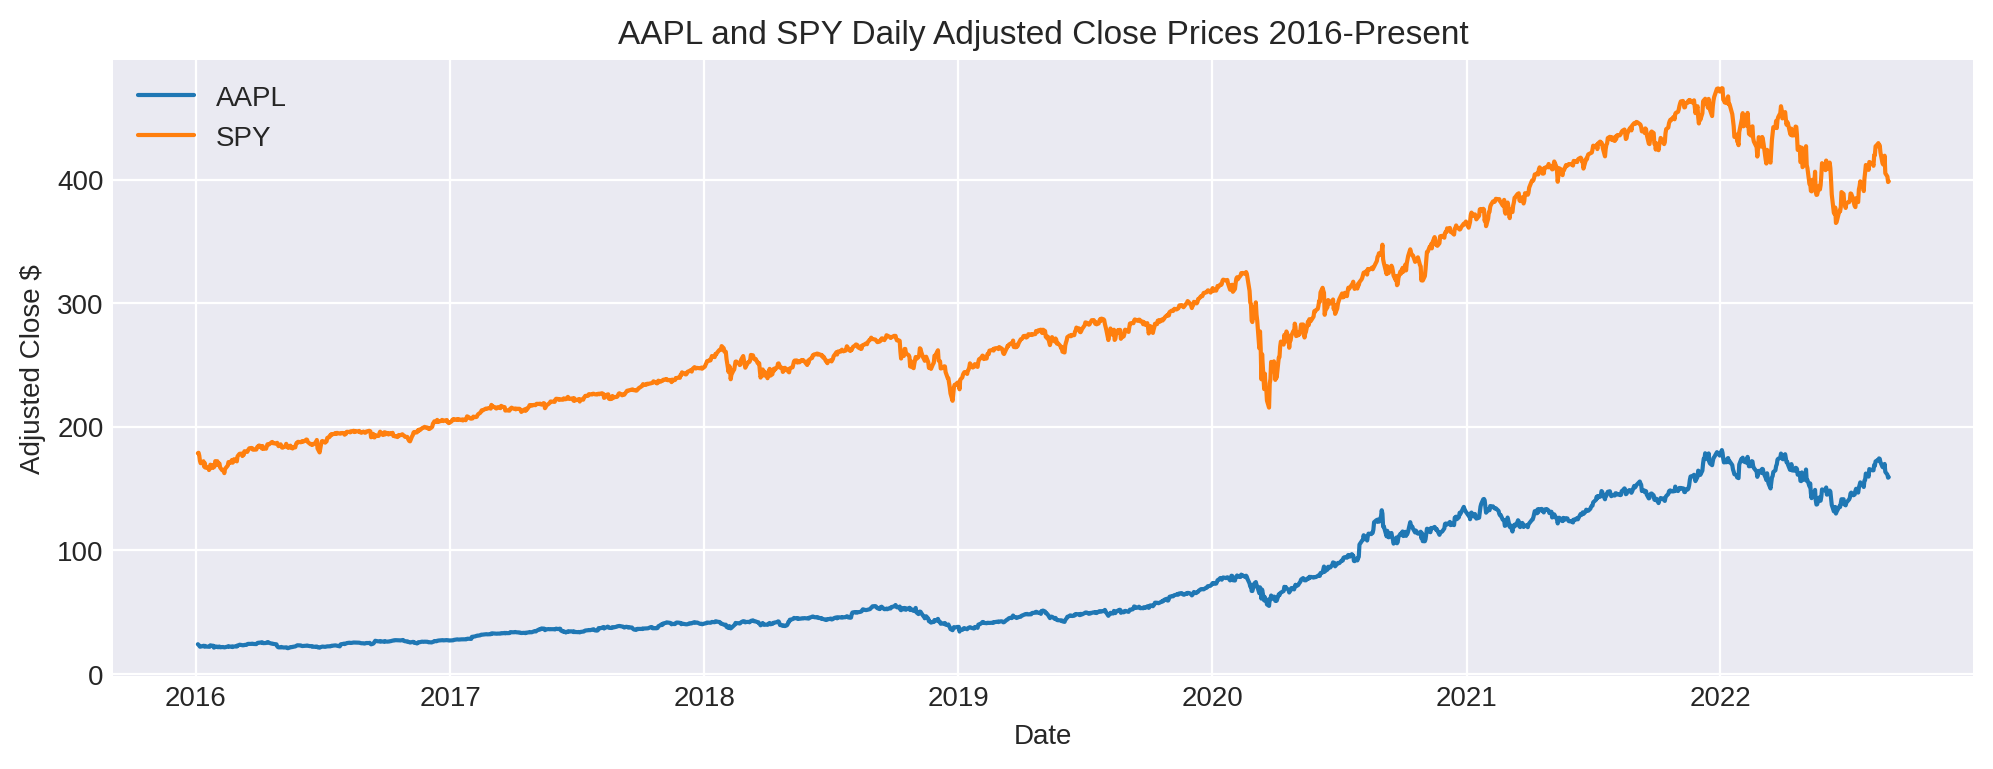

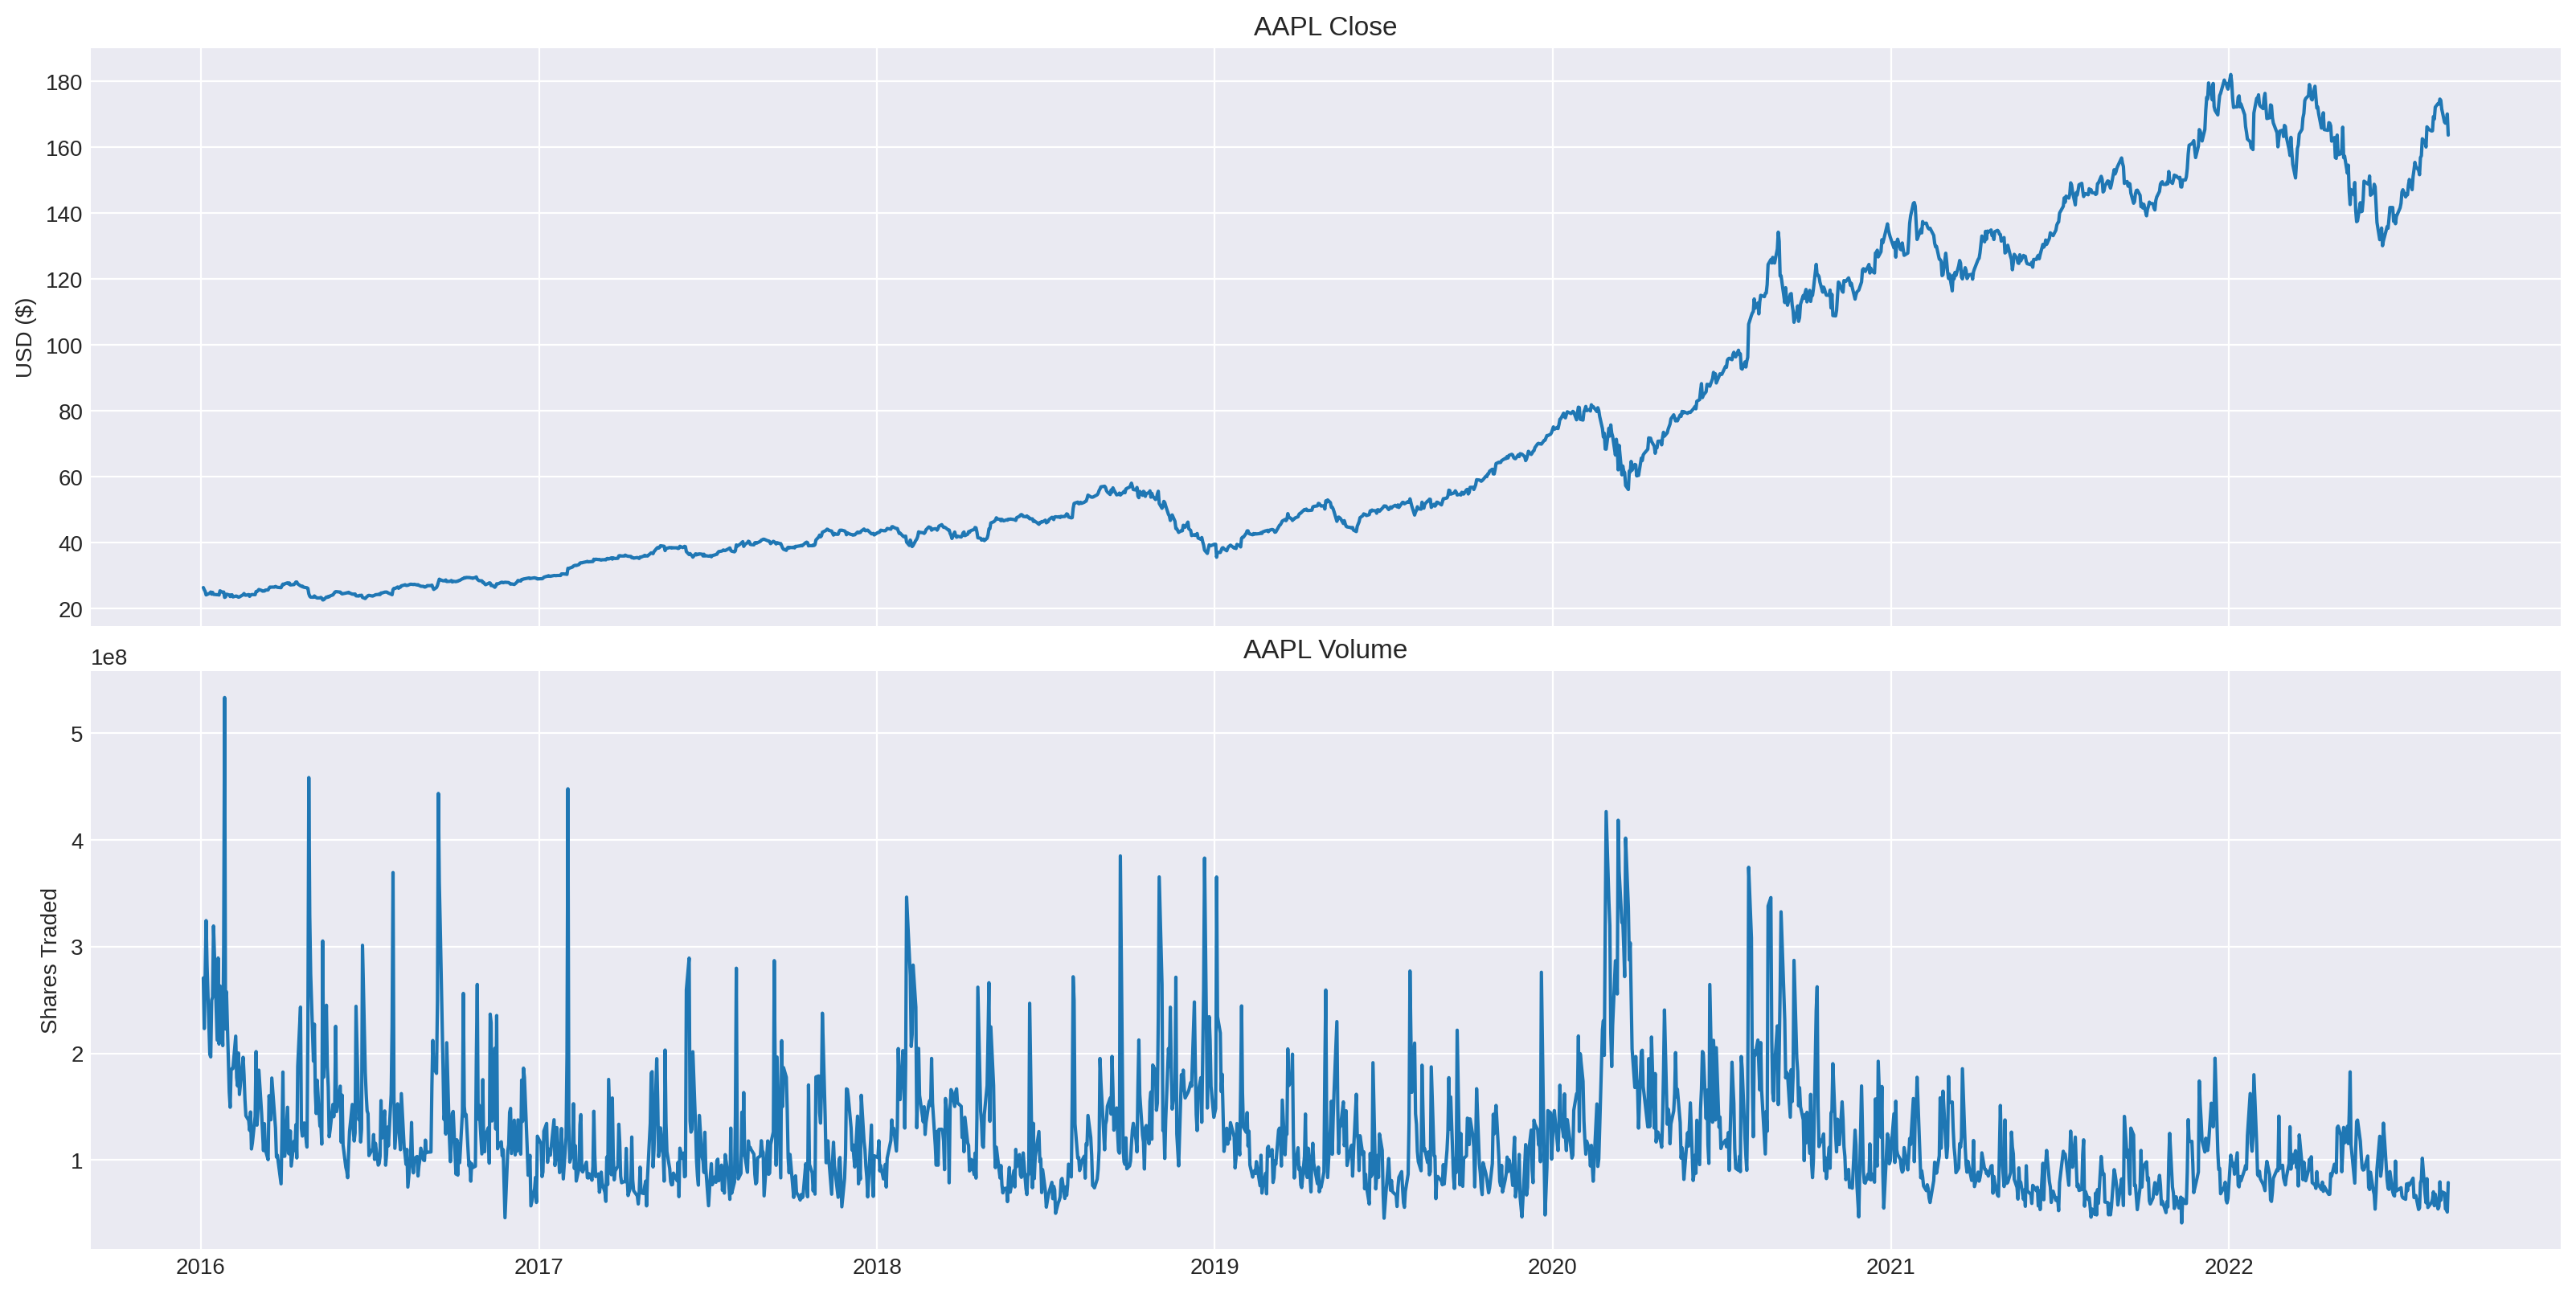

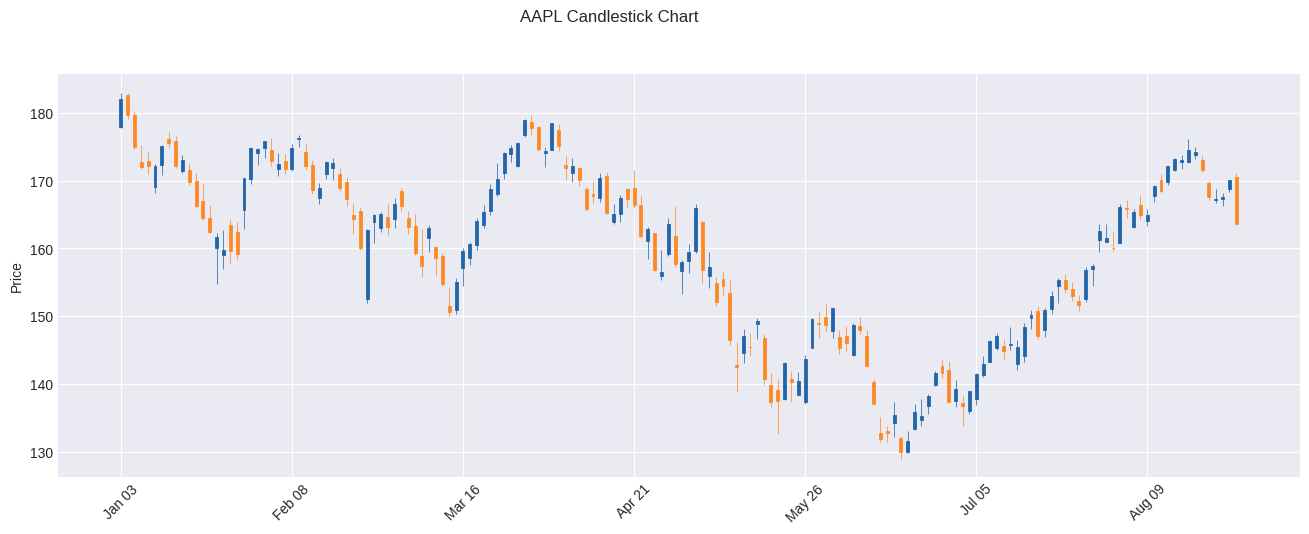

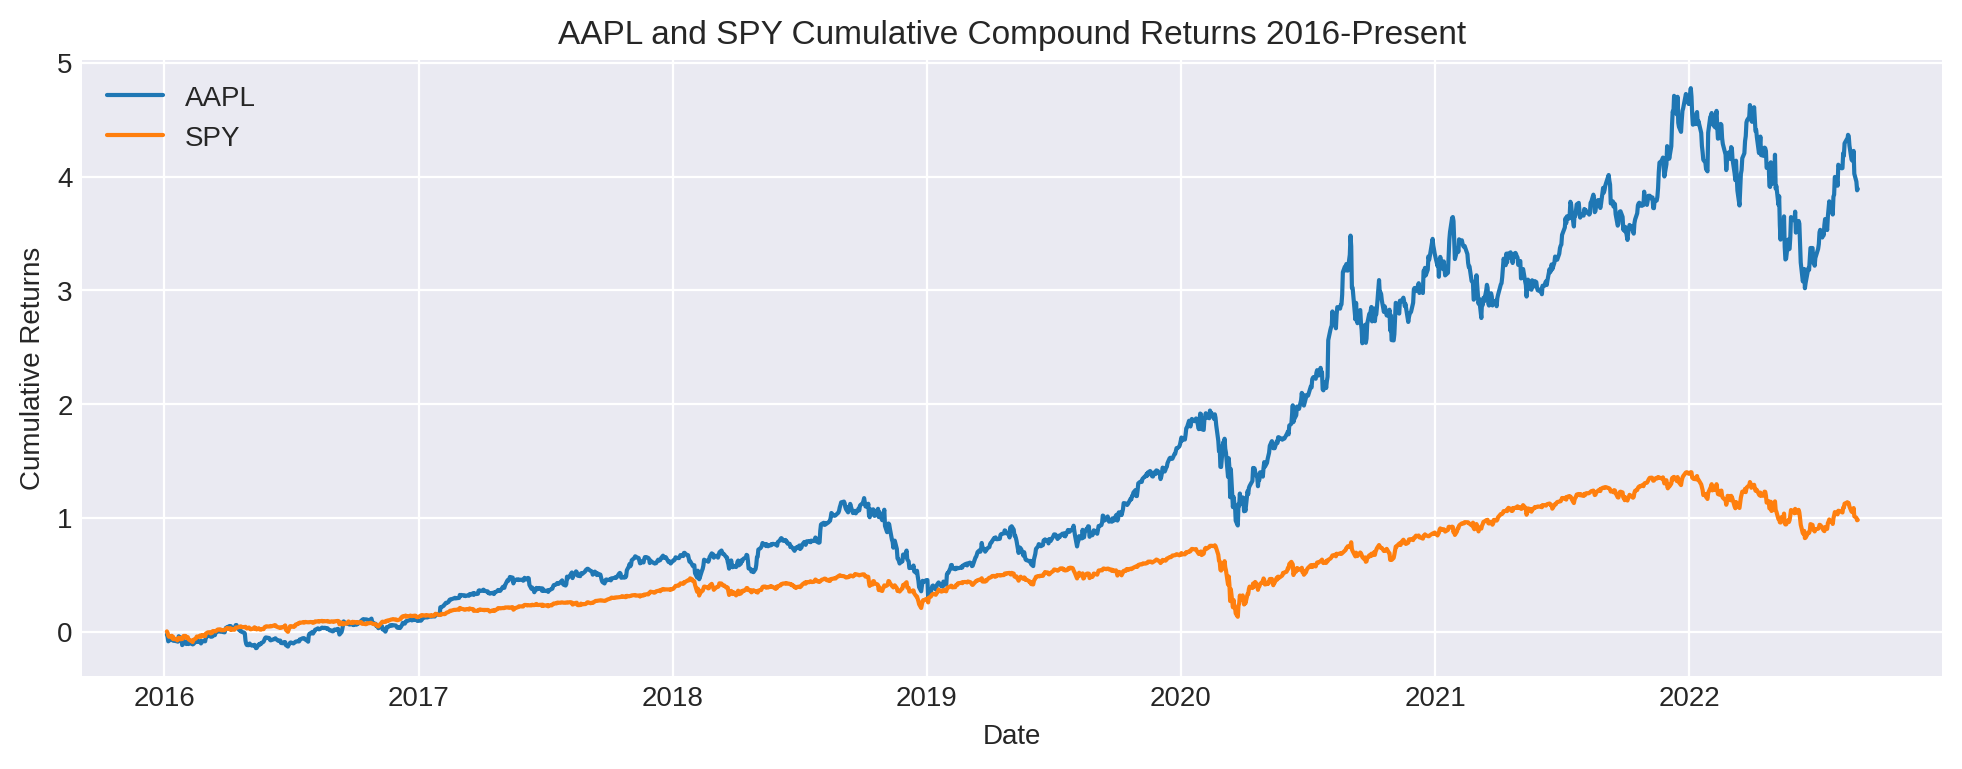

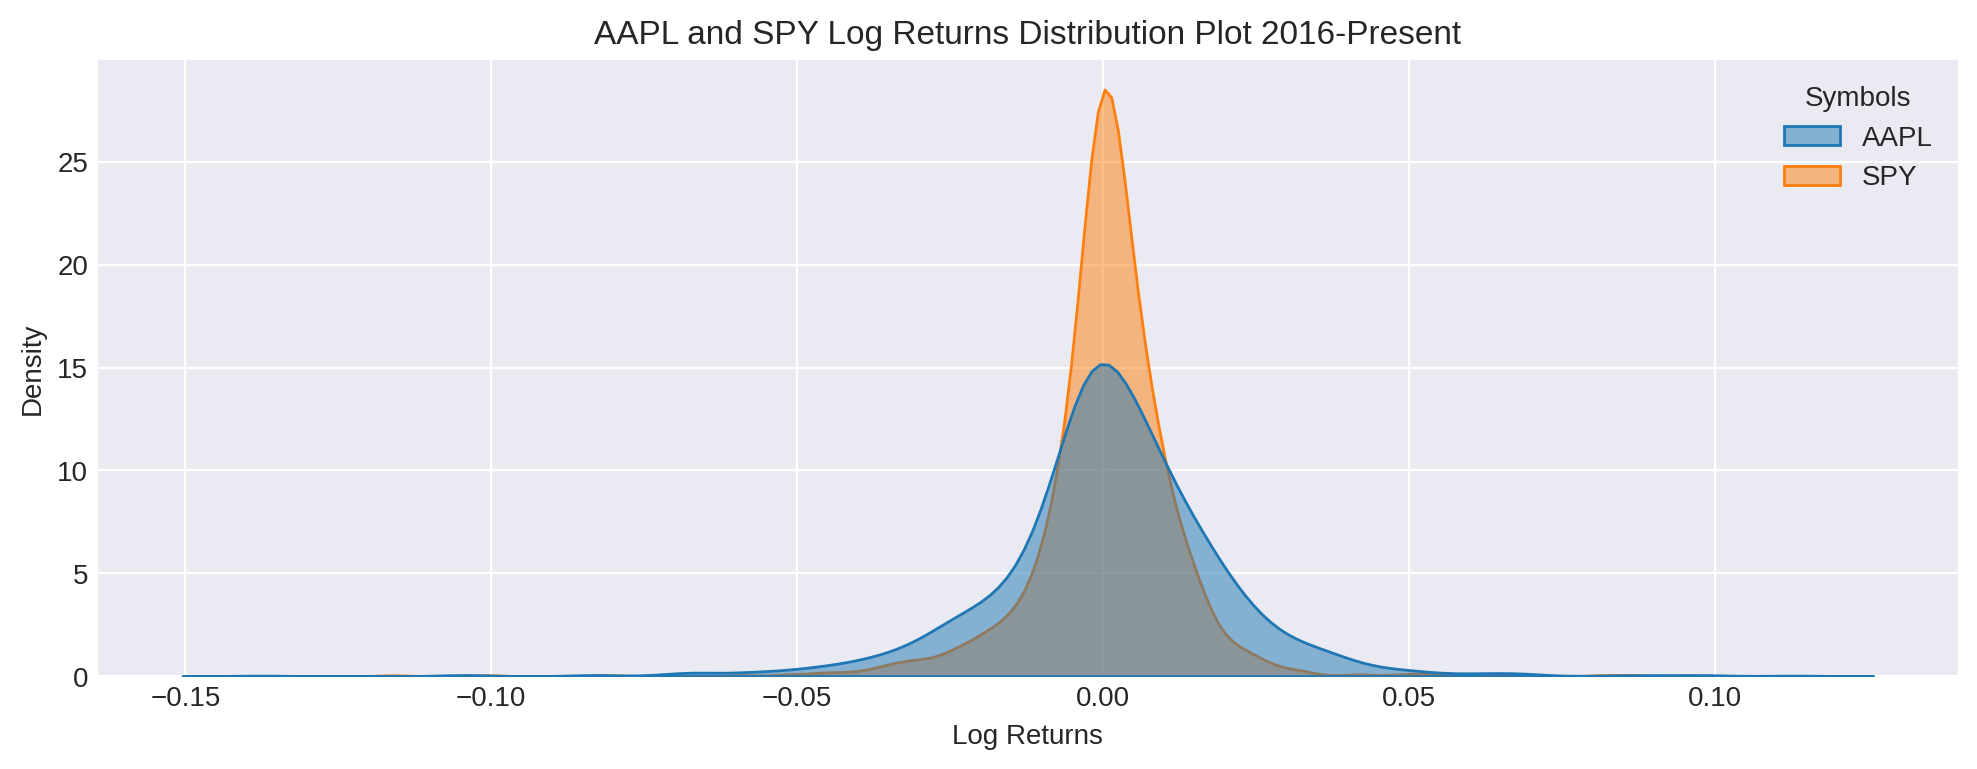

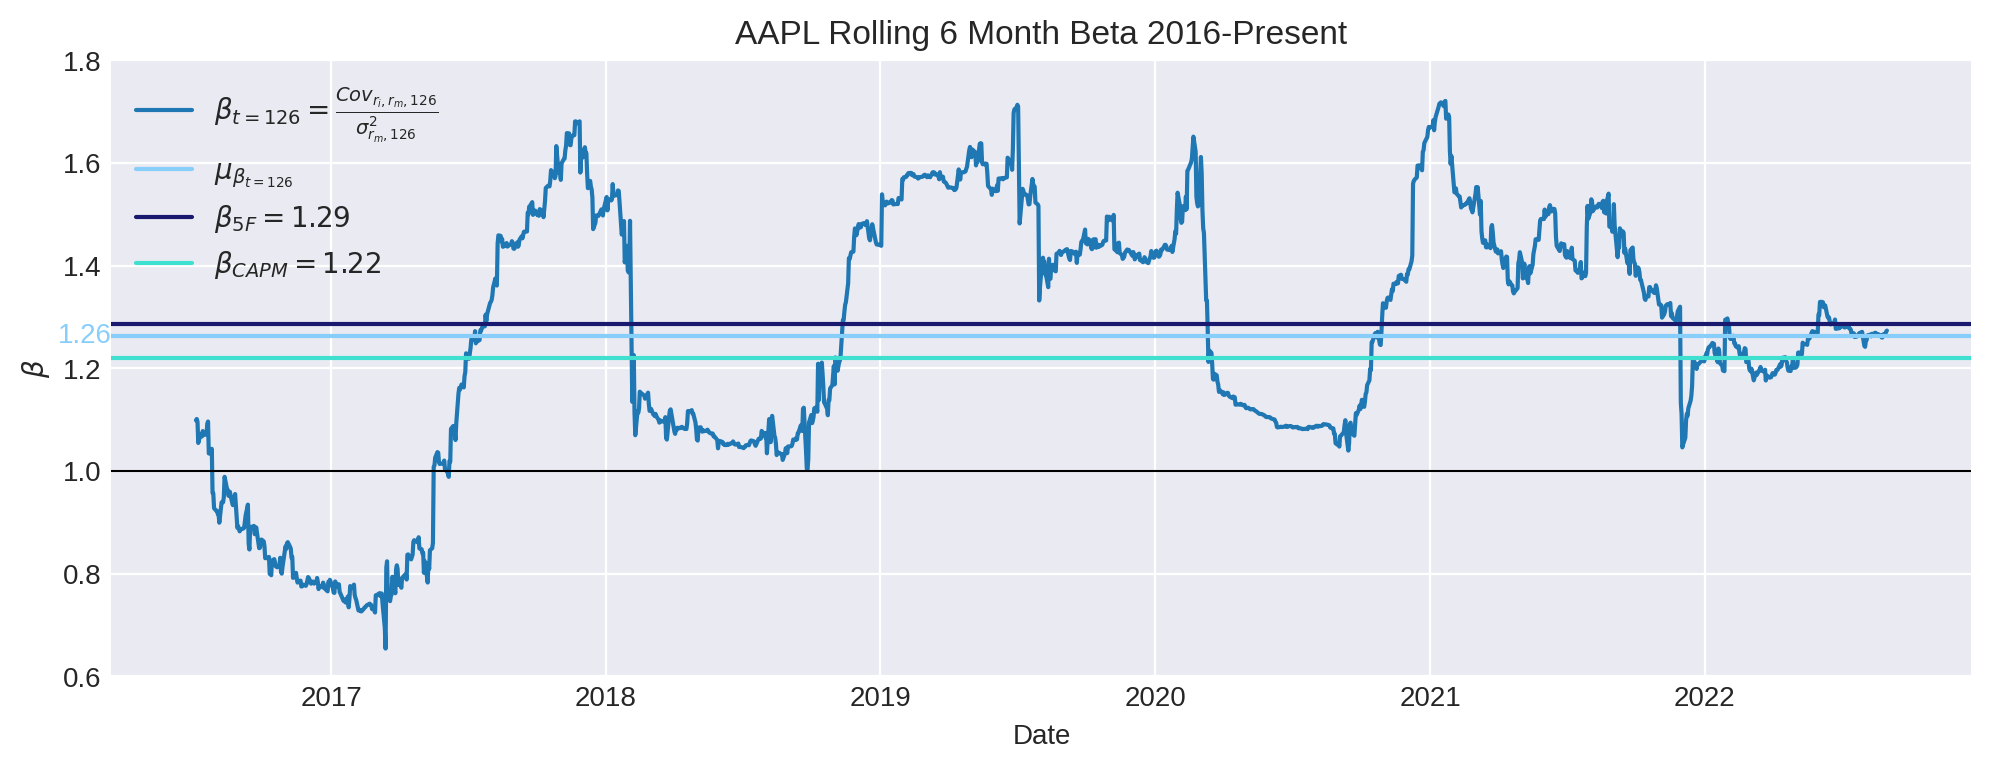

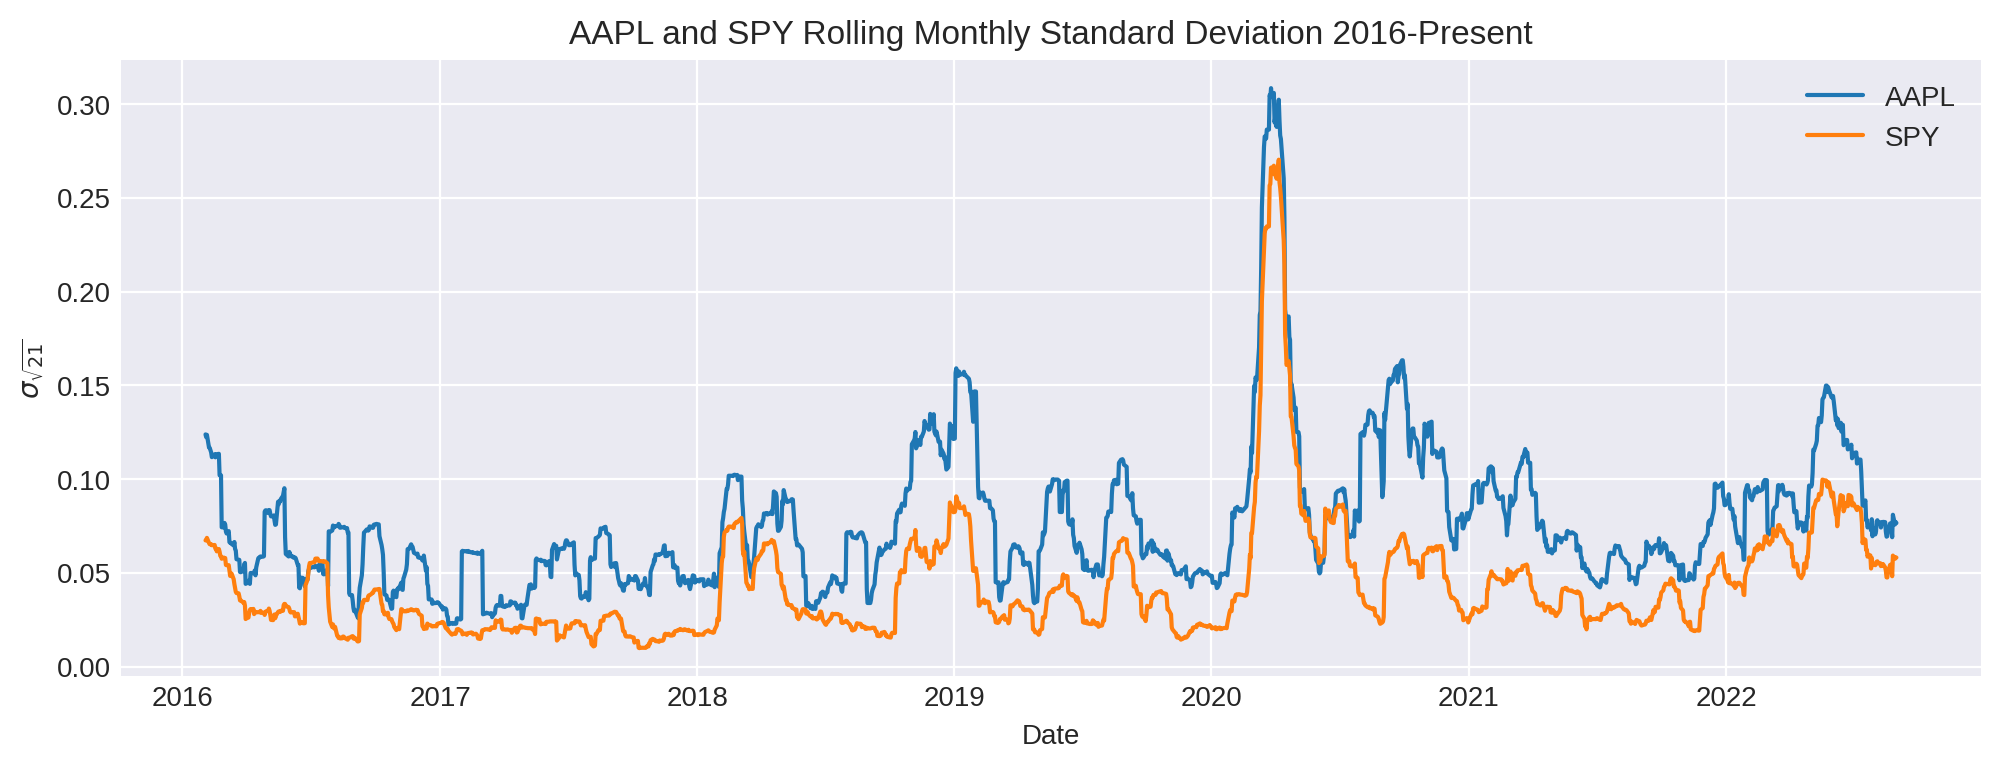

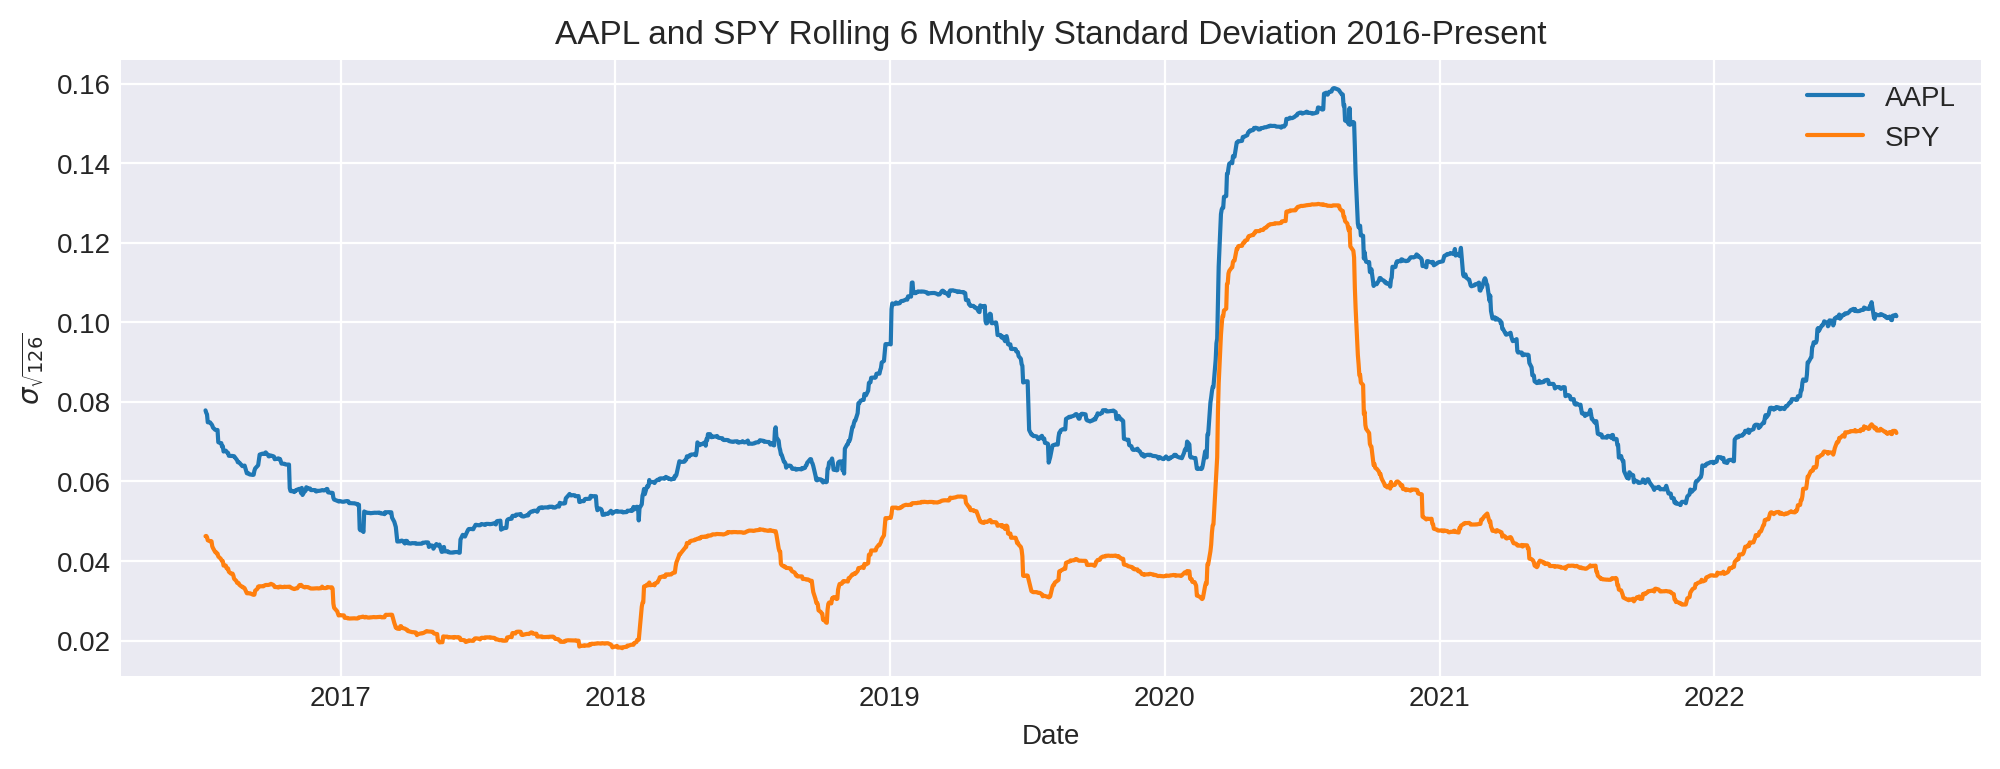

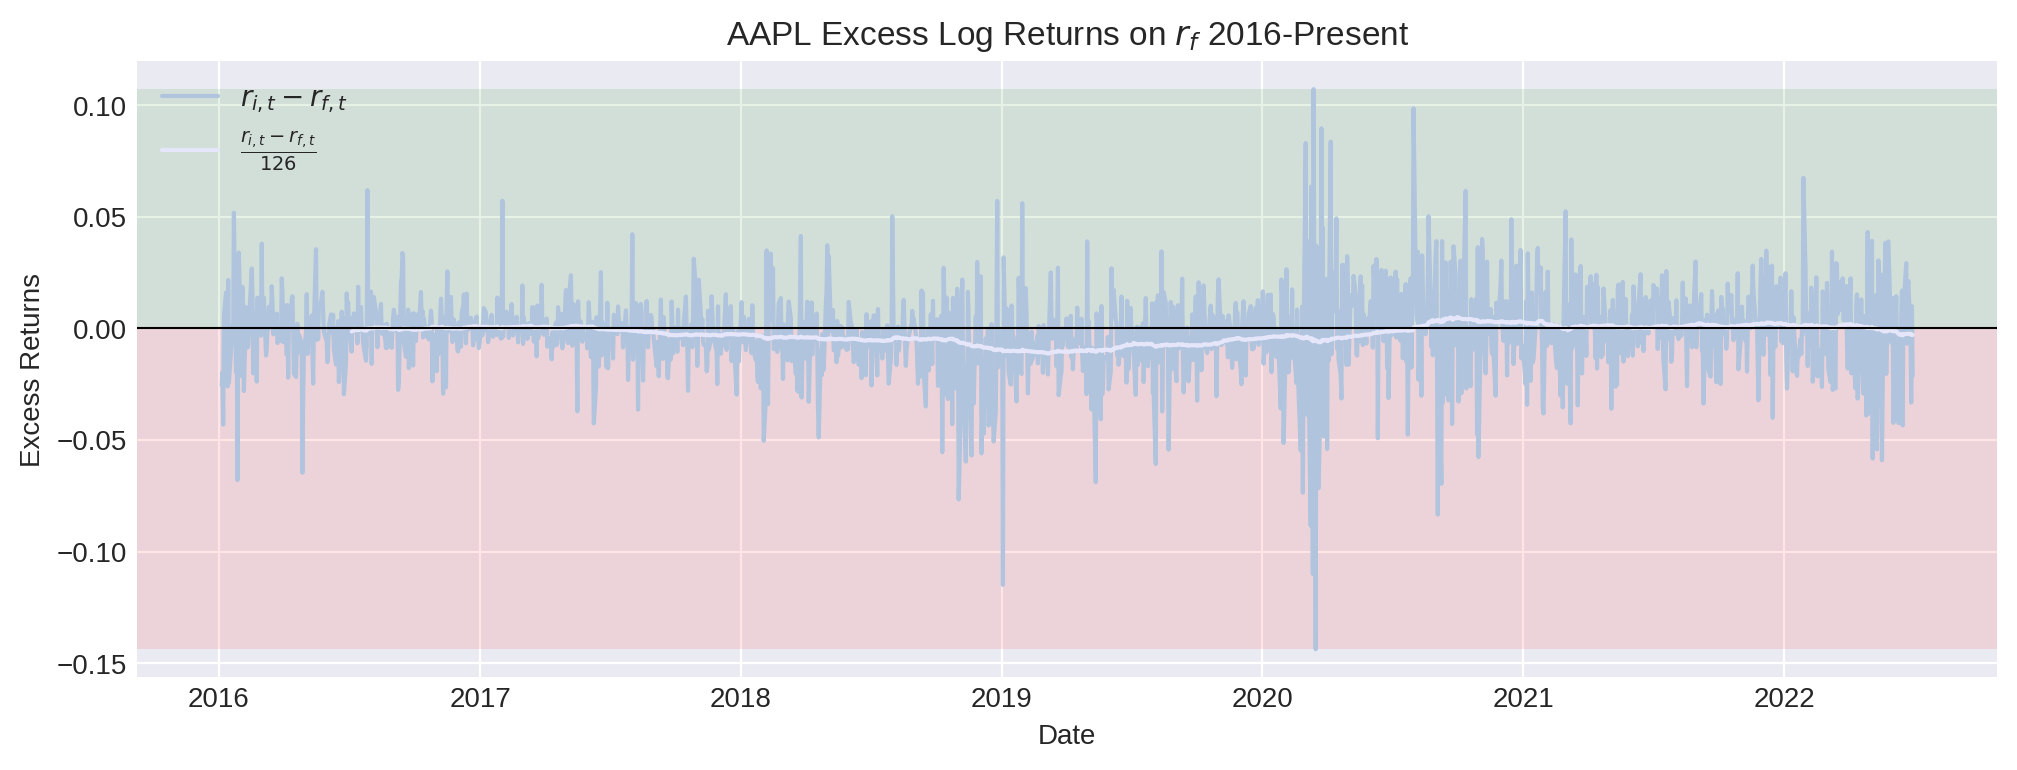

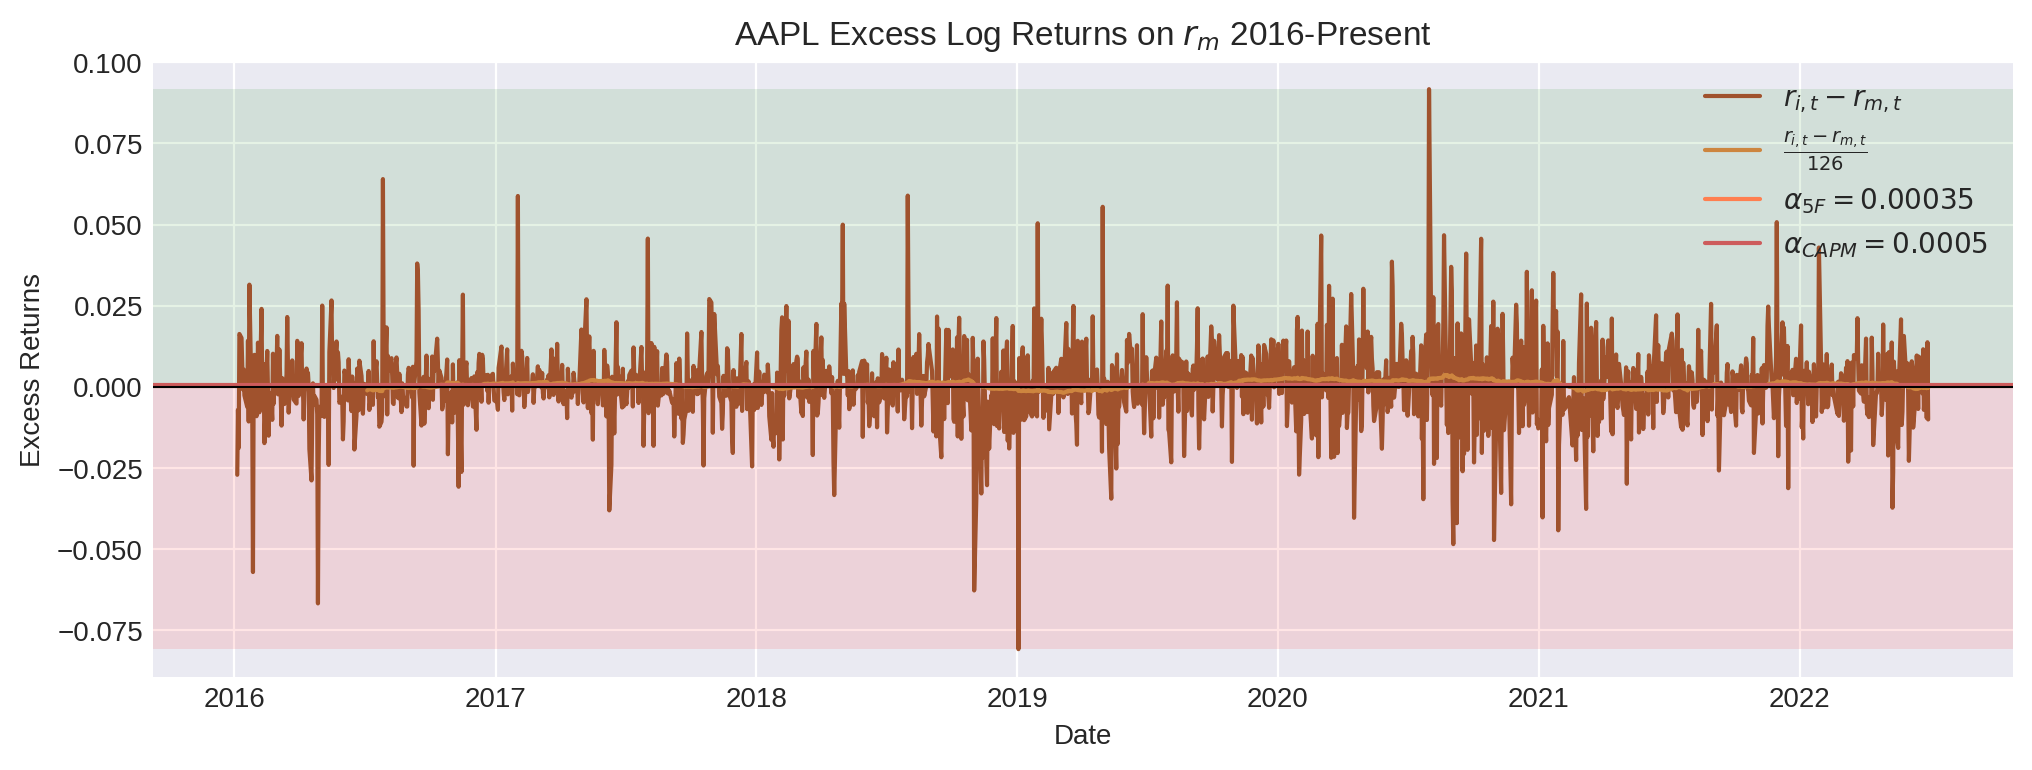

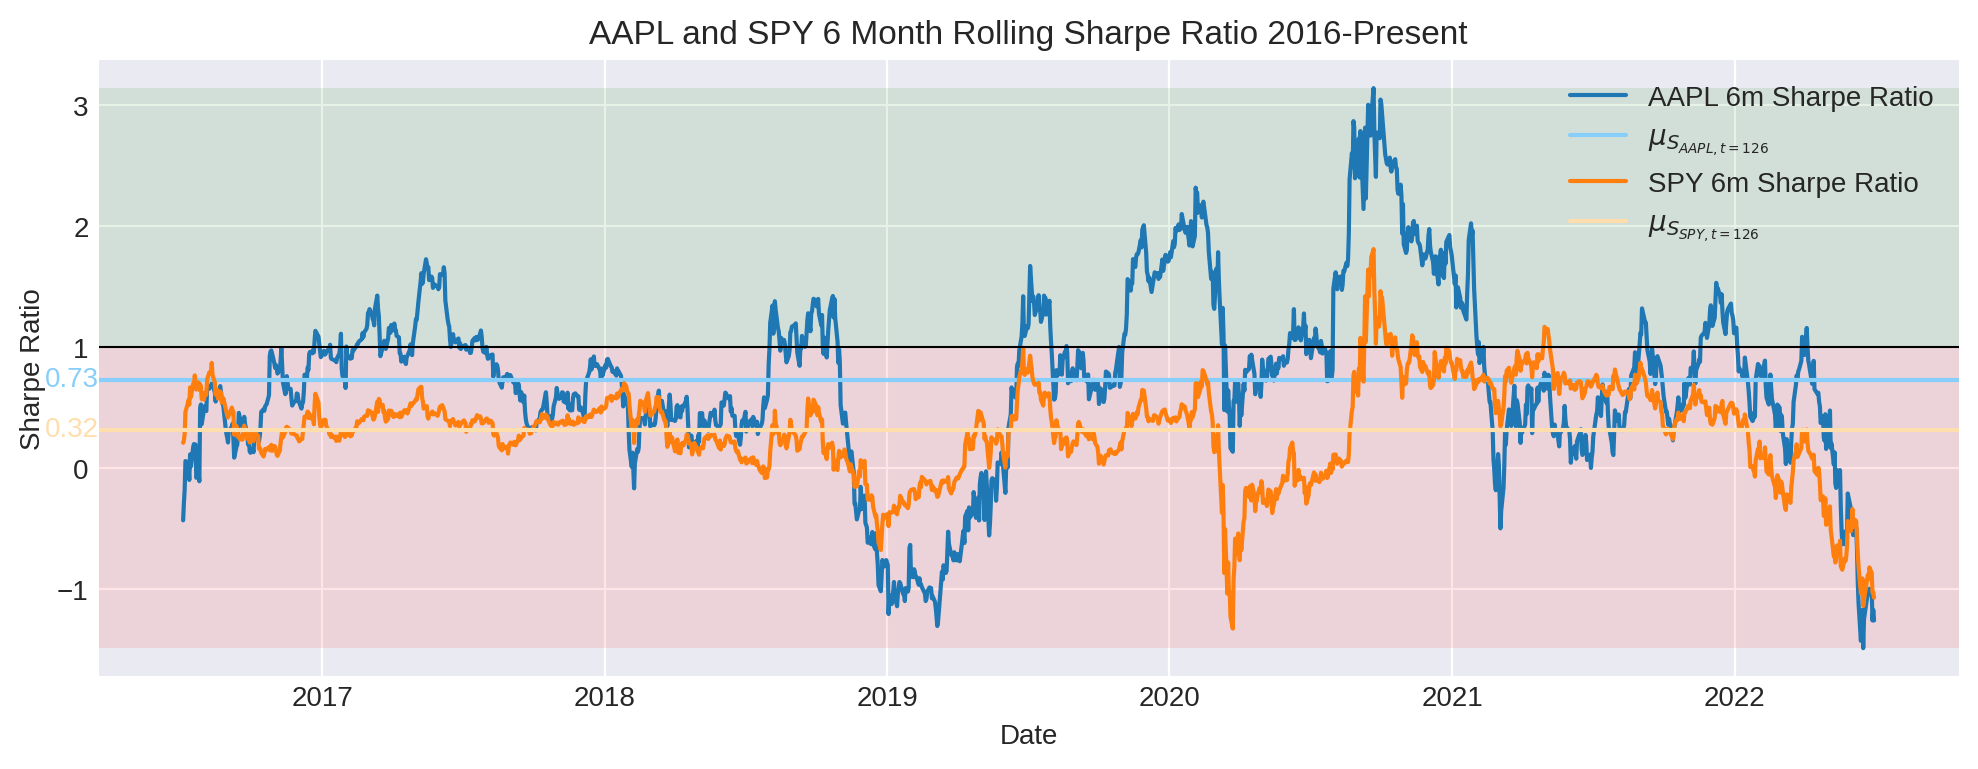





Relevant Descriptive Statistics:


,count,mean,std,min,25%,50%,75%,max
AAPL,1634.0,0.001060,0.018881,-0.137708,-0.006799,0.000994,0.010389,0.113157
SPY,1634.0,0.000457,0.011820,-0.115886,-0.003294,0.000723,0.005753,0.086731
Excess_rf,1634.0,-0.002277,0.019236,-0.143708,-0.010494,-0.001920,0.006938,0.107157
Excess_SPY,1634.0,0.000603,0.012455,-0.080772,-0.005684,0.000283,0.006714,0.091692


In [ ]:
# Plots:
plt.style.use('seaborn-darkgrid')
plt.tight_layout()

fig, ax = plt.subplots(figsize=(12,4), dpi=200)
ax.plot(stonks['AAPL'], label = 'AAPL')
ax.plot(stonks['SPY'], label = 'SPY')
ax.legend(loc='best')
ax.set_title('AAPL and SPY Daily Adjusted Close Prices 2016-Present')
ax.set_xlabel('Date')
ax.set_ylabel('Adjusted Close $')


fig, ax = plt.subplots(2, sharex = True, figsize=(16, 8), dpi=200)
plt.tight_layout()
ax[0].plot(ohlcv.index, ohlcv['Close'])
ax[0].set_title('AAPL Close')
ax[0].set_ylabel('USD ($)')
ax[1].set_title('AAPL Volume')
ax[1].set_ylabel('Shares Traded')
ax[1].plot(ohlcv.index, ohlcv['Volume'])

mc = mpf.make_marketcolors(up='#0b559f',down='#ff7f0e',
                           edge={'up':'#0b559f', 'down':'#ff7f0e'},
                           wick={'up':'#0b559f','down':'#ff7f0e'},
                           ohlc='black')
s  = mpf.make_mpf_style(base_mpl_style='seaborn-darkgrid',marketcolors=mc)
mpf.plot(ohlcv['2022-01-01':], type="candle", style=s, title='AAPL Candlestick Chart', figratio=(12/1200,4/1200))

fig, ax = plt.subplots(figsize=(12,4), dpi=200)
ax.plot(cum_ret['AAPL'], label = 'AAPL')
ax.plot(cum_ret['SPY'], label = 'SPY')
ax.legend(loc='best')
ax.set_title('AAPL and SPY Cumulative Compound Returns 2016-Present')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Returns')

fig, ax = plt.subplots(figsize=(12,4), dpi=200)
ax = sns.kdeplot(data=log_stonks, fill=True, alpha=0.5);
ax.set_title('AAPL and SPY Log Returns Distribution Plot 2016-Present')
ax.set_xlabel('Log Returns')
ax.set_ylabel('Density')


fig, ax = plt.subplots(figsize=(12,4), dpi=200)
ax.plot(rolling_6m_beta, label = r'$\beta_{t=126} = \frac{Cov_{r_i, r_m, 126}}{\sigma^2_{r_m, 126}}$')
ax.axhline(rolling_6m_beta.mean(), color='lightskyblue', label = r'$\mu_{\beta_{t=126}}$')
ax.text(0,rolling_6m_beta.mean(), "{:.2f}".format(rolling_6m_beta.mean()), color="lightskyblue", ha="right", va="center",transform=ax.get_yaxis_transform())
ax.axhline(FF_beta, color = 'midnightblue', label = r'$\beta_{5F}=1.29$')
ax.axhline(CAPM_beta, color = 'turquoise', label = r'$\beta_{CAPM}=1.22$')
ax.axhline(1, color='black', linewidth=0.75)
ax.legend(loc='best')
ax.set_title('AAPL Rolling 6 Month Beta 2016-Present')
ax.set_xlabel('Date')
ax.set_ylabel(r'$\beta$')
plt.ylim(0.6, 1.8)


fig, ax = plt.subplots(figsize=(12,4), dpi=200)
ax.plot(rolling_21d_std['AAPL'], label='AAPL')
ax.plot(rolling_21d_std['SPY'], label='SPY')
ax.legend(loc='best')
ax.set_title('AAPL and SPY Rolling Monthly Standard Deviation 2016-Present')
ax.set_xlabel('Date')
ax.set_ylabel(r'$\sigma_{\sqrt{21}}$')


fig, ax = plt.subplots(figsize=(12,4), dpi=200)
ax.plot(rolling_6m_std['AAPL'], label='AAPL')
ax.plot(rolling_6m_std['SPY'], label='SPY')
ax.legend(loc='best')
ax.set_title('AAPL and SPY Rolling 6 Monthly Standard Deviation 2016-Present')
ax.set_xlabel('Date')
ax.set_ylabel(r'$\sigma_{\sqrt{126}}$')


fig, ax = plt.subplots(figsize=(12,4), dpi=200)
ax.plot(fama_french['Excess_rf'], color = 'lightsteelblue', label = r'$r_{i,t}-r_{f,t}$')
ax.plot(fama_french['Excess_rf_mean_126'], color = 'lavender', label = r'$\frac{r_{i,t}-r_{f,t}}{126}$')
ax.axhline(0, color='black', linewidth=0.75)
ax.axhspan(0, fama_french['Excess_rf'].max(), facecolor='g', alpha=0.1)
ax.axhspan(0, fama_french['Excess_rf'].min(), facecolor='r', alpha=0.1)
ax.legend(loc='best')
ax.set_title('AAPL Excess Log Returns on $r_f$ 2016-Present')
ax.set_xlabel('Date')
ax.set_ylabel('Excess Returns')

fig, ax = plt.subplots(figsize=(12,4), dpi=200)
ax.plot(fama_french['Excess_SPY'], color = 'sienna', label = r'$r_{i,t}-r_{m,t}$')
ax.plot(fama_french['Excess_SPY_mean_126'], color = 'peru', label = r'$\frac{r_{i,t}-r_{m,t}}{126}$')
ax.axhline(FF_alpha, color = 'coral', label = r'$\alpha_{5F}=0.00035$')
ax.axhline(CAPM_alpha, color = 'indianred', label = r'$\alpha_{CAPM}=0.0005$')
ax.axhline(0, color='black', linewidth=0.75)
ax.axhspan(0, fama_french['Excess_SPY'].max(), facecolor='g', alpha=0.1)
ax.axhspan(0, fama_french['Excess_SPY'].min(), facecolor='r', alpha=0.1)
ax.legend(loc='best')
ax.set_title('AAPL Excess Log Returns on $r_m$ 2016-Present')
ax.set_xlabel('Date')
ax.set_ylabel('Excess Returns')

fig, ax = plt.subplots(figsize=(12,4), dpi=200)
ax.plot(sharpe_aapl_6m, label = 'AAPL 6m Sharpe Ratio')
ax.axhline(sharpe_aapl_6m.mean(), color = 'lightskyblue', label = r'$\mu_{S_{AAPL, t=126}}$')
ax.text(0,sharpe_aapl_6m.mean(), "{:.2f}".format(sharpe_aapl_6m.mean()), color="lightskyblue", ha="right", va="center", transform=ax.get_yaxis_transform())
ax.plot(sharpe_spy_6m, label = 'SPY 6m Sharpe Ratio')
ax.axhline(sharpe_spy_6m.mean(), color = 'navajowhite', label = r'$\mu_{S_{SPY, t=126}}$')
ax.text(0,sharpe_spy_6m.mean(), "{:.2f}".format(sharpe_spy_6m.mean()), color="navajowhite",  ha="right", va="center",transform=ax.get_yaxis_transform())
ax.axhline(1, color='black', linewidth=0.75)
ax.axhspan(1, sharpe_aapl_6m.max(), facecolor='g', alpha=0.1)
ax.axhspan(1, sharpe_aapl_6m.min(), facecolor='r', alpha=0.1)
ax.legend(loc='best')
ax.set_title('AAPL and SPY 6 Month Rolling Sharpe Ratio 2016-Present')
ax.set_xlabel('Date')
ax.set_ylabel('Sharpe Ratio')
plt.show();

print('\n')
print('\n')
print('\033[1m' + 'Relevant Descriptive Statistics:' + '\033[0m')
fama_french[['AAPL', 'SPY', 'Excess_rf', 'Excess_SPY']].describe().T

# Forecasting:

In [ ]:
# Add Predictions and Forecasts:
# LSTM
# Create a new dataframe with only the'Close column
data=stonks['AAPL']
# Convert the dataframe toanumpy array
dataset=data.values
# Get the number of rows to train the model on
training_data_len=math.ceil(len(dataset)*.997)


# Scale the data:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset.reshape(-1,1))
scaled_data

#Create the training data set
#Create the scaled training data set
train_data=scaled_data[0:training_data_len,:]
#Split the data into x_train and y_train data sets
x_train = []
y_train = []
for i in range(5,len(train_data)):
  x_train.append(train_data[i-5:i,0]),
  y_train.append(train_data[i,0])

#Convert the x_train and y_train to numpy arrays
x_train,y_train=np.array(x_train),np.array(y_train)
#Reshape the data
x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

# Build LSTM model:
model = Sequential()
model.add(LSTM(100, activation='sigmoid', input_shape=(x_train.shape[1], 1)))
model.add(Dense(50))
model.add(Dense(1))

# Compile the model:
model.compile(optimizer='adam', loss='mean_squared_error')
# Train the model:
model.fit(x_train, y_train, batch_size=1, epochs=25)

loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch);


# Create the testing dataset:
# Create a new array containing scaled values from index 1276:
test_data=scaled_data[training_data_len-5:, :] # 5 day lookback period - Saud and Shakya (2020).
# Create the datasets x_test and y_test:
x_test = []
y_test = dataset[training_data_len:]
for i in range (5,len(test_data)): 
  x_test.append(test_data[i-5:i, 0])

# Convert the data to a numpy array:
x_test=np.array(x_test)

# Reshape the dataset - LSTM model expects 3D shape
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
pred = pd.DataFrame(predictions)
valid = pd.DataFrame(data[training_data_len:])
valid['Predictions'] = pred[0].values



In [ ]:
# ARIMA 
# Separate train test split:
train_start_dt = '2016-01-04' # 0
test_start_dt = '2022-08-22' # last five days
train = stonks['AAPL'].copy()[(stonks['AAPL'].index >= train_start_dt) & (stonks['AAPL'].index < test_start_dt)]
test = stonks['AAPL'].copy()[stonks['AAPL'].index >= test_start_dt]

# scale the data:
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train.values.reshape(-1,1))
test_data = scaler.transform(test.values.reshape(-1,1))

# Compile and Fit Model

model = ARIMA(endog=train_data, order = (1,2,2))
result = model.fit(disp=0)
result.summary()

steps = 5
fc,se,conf = result.forecast(steps)
fc = scaler.inverse_transform(fc.reshape(-1,1))
se = scaler.inverse_transform(se.reshape(-1,1))
conf = scaler.inverse_transform(conf)
fc=pd.Series(fc.flatten(),index=test[:steps].index)
lower=pd.Series(conf[:,0],index=test[:steps].index)
upper=pd.Series(conf[:,1],index=test[:steps].index)

print('ARIMA MAPE for testing data: ', str(mean_absolute_percentage_error(fc, test)*100) + '%')



ARIMA MAPE for testing data:  2.075575017666818%


In [ ]:
# SVR - Hyperparameter Tuning via Gridsearch Cross-Validation:
from sklearn import linear_model
from sklearn import svm

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ('linear', 'rbf','poly'), 
                     'C':[0.001, 0.10, 0.1, 10, 25, 50, 100, 1000],
                     'gamma': [0.4, 0.45, 0.5, 0.55, 0.6],
                     'epsilon':[0.01,0.02,0.03, 0.04, 0.05]}
                   ]

scores = ['precision']
svr = svm.SVR()
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    clf = GridSearchCV(svr, tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(x_train, y_train[:,0])

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
        
clf.best_params_

In [ ]:
# Create SVR Dataset:
stonks_aapl = stonks['AAPL']
stonks_aapl

# Separate train test split:
train_start_dt = '2016-01-04' # 0 - 2016-01-04
test_start_dt = '2022-08-19' # last 5 days
train = stonks_aapl.copy()[(stonks_aapl.index >= train_start_dt) & (stonks_aapl.index < test_start_dt)]
test = stonks_aapl.copy()[stonks_aapl.index >= test_start_dt]


# scale the data:
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train.values.reshape(-1,1))
test_data = scaler.transform(test.values.reshape(-1,1))

timesteps = 2
# converting training and test data to 2D tensor using nested list comprehension:
train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,0]
train_data_timesteps.shape
test_data_timesteps=np.array([[j for j in test_data[i:i+timesteps]] for i in range(0,len(test_data)-timesteps+1)])[:,:,0]



# Selecting inputs and outputs from training and testing data:
x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]
x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,[timesteps-1]]

# Compile and fit model:
model = SVR(kernel='rbf',gamma=0.4, C=10, epsilon = 0.01)
model.fit(x_train, y_train[:,0])


y_train_pred = model.predict(x_train).reshape(-1,1)
y_test_pred = model.predict(x_test).reshape(-1,1)



# Scaling the predictions
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)



# Scaling the original values
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)



# Obtain Timestamps
train_timestamps = stonks_aapl[(stonks_aapl.index < test_start_dt) & (stonks_aapl.index >= train_start_dt)].index[timesteps-1:]
test_timestamps = stonks_aapl[test_start_dt:].index[timesteps-1:]
print(test_timestamps, y_test)



In [ ]:
# Visualise LSTM Forecast against AAPL:
plt.figure(figsize=(16,8), dpi=200)
plt.title('Long Short-Term Memory Model Forecast Against Actual Values:', fontsize=24)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Adjusted Close USD ($)', fontsize=18)
plt.plot(stonks['AAPL'][-5:], label = 'AAPL Adjusted Close Price')
plt.plot(valid['Predictions'], label = 'Prediction')
plt.legend(loc='best')
plt.show();

# Visualise ARIMA Forecast against AAPL:
plt.figure(figsize=(16,8), dpi=200)
plt.xlabel('Timestamp')
plt.ylabel('AAPL Share Price USD ($)')
plt.title('ARIMA Model Forecast AGainst Actual Values:', fontsize=24)
plt.plot(stonks['AAPL'][-5:])
plt.plot(fc, linewidth=2.0)
plt.fill_between(lower.index,lower,upper,color="k",alpha=0.1)
plt.legend(['Actual','Predicted'])
plt.show();

# Visualise SVR Forecast against AAPL:
plt.figure(figsize=(15,8), dpi=200)
plt.plot(test_timestamps, y_test)
plt.plot(test_timestamps, y_test_pred)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.title('SVR Model Forecast AGainst Actual Values:')
plt.show();

# Visualise the three forecasts against AAPL for comparison:
plt.figure(figsize=(16,8), dpi=200)
plt.title('Model Forecasts Against AAPL Adj. Close:', fontsize=24)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Adjusted Close USD ($)', fontsize=18)
plt.plot(stonks['AAPL'][-5:], label = 'AAPL Adjusted Close')
plt.plot(valid['Predictions'], label = 'LSTM Prediction')
plt.plot(test_timestamps, y_test_pred, label = 'SVR Prediction')
plt.plot(fc, label = 'ARIMA Prediction')
plt.fill_between(lower.index,lower,upper,color="k",alpha=0.1)
plt.legend(loc='best')
plt.show();

# Get the Mean Absolute Percentage Errors (MAPEs)
print('\n')
print('LSTM MAPE for testing data: ', str(mean_absolute_percentage_error(valid['Predictions'], valid['AAPL'])*100) + '%')
print('ARIMA MAPE for testing data: ', str(mean_absolute_percentage_error(fc, test)*100) + '%')
print('SVR MAPE for testing data: ', str(mean_absolute_percentage_error(y_test_pred, y_test)*100) + '%')

# Technical Analysis:

In [ ]:
# add ta and backtest:
import pandas_ta as ta
ohlcv.ta.macd(cumulative=True, append=True)
ohlcv.ta.rsi(cumulative=True, append=True)
ohlcv.ta.stoch(cumulative=True, append=True)
ohlcv.ta.mom(cumulative=True, append=True)
ohlcv.ta.mfi(cumulative=True, append=True)
ohlcv.ta.vwma(cumulative=True, append=True)
ohlcv.ta.psl(cumulative=True, append=True)
ohlcv.ta.bbands(cumulative=True, append=True)
ohlcv.ta.ppo(cumulative=True, append=True)
ohlcv.ta.fwma(cumulative=True, append=True)
ohlcv.ta.psar(cumulative=True, append=True)
ohlcv.ta.adx(cumulative=True, append=True)
ohlcv.ta.obv(cumulatire=True, append=True)
ohlcv.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'MACD_12_26_9',
       'MACDh_12_26_9', 'MACDs_12_26_9', 'RSI_14', 'STOCHk_14_3_3',
       'STOCHd_14_3_3', 'MOM_10', 'MFI_14', 'VWMA_10', 'PSL_12', 'BBL_5_2.0',
       'BBM_5_2.0', 'BBU_5_2.0', 'BBB_5_2.0', 'BBP_5_2.0', 'PPO_12_26_9',
       'PPOh_12_26_9', 'PPOs_12_26_9', 'FWMA_10', 'PSARl_0.02_0.2',
       'PSARs_0.02_0.2', 'PSARaf_0.02_0.2', 'PSARr_0.02_0.2', 'ADX_14',
       'DMP_14', 'DMN_14', '30', '70', 'OBV'],
      dtype='object', name='Attributes')

In [ ]:
# Visualisations
plt.figure(figsize=(16,8), dpi=200)
plt.plot(ohlcv['MACD_12_26_9'], label = '$MACD_{12,26}$')
plt.plot(ohlcv['MACDs_12_26_9'], linestyle = ':', label = '$MACDs_{9}$')
plt.title('AAPL Moving Average Convergence Divergence')
plt.legend()

plt.figure(figsize=(16,8), dpi=200)
plt.plot(ohlcv['PPO_12_26_9'], label = '$PPO_{12,26}$')
plt.plot(ohlcv['PPOs_12_26_9'], linestyle = ':', label = '$PPOs_{9}$')
plt.title('AAPL percentage Price Oscillator')
plt.legend()


plt.figure(figsize=(16,8), dpi=200)
plt.plot(ohlcv['MFI_14'], label = '$MFI_{14}$')
plt.axhline(y = 80, color = 'r', label = 'Overbought')
plt.axhline(y = 20, color = 'g', label = 'Oversold')
plt.axhspan(80, 100, color='red', alpha = 0.1)
plt.axhspan(0,20,color='green', alpha = 0.1)
plt.title('AAPL Money Flow Index')
plt.legend()

plt.figure(figsize=(16,8), dpi=200)
plt.plot(ohlcv['RSI_14'], label = '$RSI_{14}$')
plt.axhline(y = 70, color = 'r', label = 'Overbought')
plt.axhline(y = 30, color = 'g', label = 'Oversold')
plt.axhspan(70, 100, color='red', alpha = 0.1)
plt.axhspan(0,30,color='green', alpha = 0.1)
plt.title('AAPL Relative Strength Index')
plt.legend()

plt.figure(figsize=(16,8), dpi=200)
plt.plot(ohlcv['STOCHk_14_3_3'], label = '$STOCHk_{14}$')
plt.axhline(y = 80, color = 'r', label = 'Overbought')
plt.axhline(y = 20, color = 'g', label = 'Oversold')
plt.axhspan(80, 100, color='red', alpha = 0.1)
plt.axhspan(0,20,color='green', alpha = 0.1)
plt.title('AAPL Stochastic Oscillator')
plt.legend()

plt.figure(figsize=(16,8), dpi=200)
plt.plot(ohlcv['Close'], label = 'AAPL Close')
plt.plot(ohlcv['VWMA_10'], label = '$VWMA_{10}$')
plt.plot(ohlcv['FWMA_10'], label = '$FWMA_{10}$')
plt.title('AAPL Close with Weighted Moving Averages')
plt.legend()

plt.figure(figsize=(16,8), dpi=200)
plt.plot(ohlcv['MOM_10'], label = '$VWMA_{10}$')
plt.title('AAPL Momentum')
plt.legend()

fig, ax = plt.subplots(2, sharex = True, figsize=(16, 8), dpi=200)
plt.tight_layout()
ax[0].plot(ohlcv.index,ohlcv['Close'], label = 'AAPL Close')
ax[0].set_title('AAPL Close')
ax[0].set_ylabel('USD($)')
ax[0].legend()
ax[1].plot(ohlcv.index,ohlcv['PSL_12'], label = '$PSL_{12}$')
ax[1].set_title('AAPL Psychological Line')
ax[1].set_ylabel('Psychological Line')
ax[1].axhline(50, color = 'black')
ax[1].axhline(50, color = 'green', alpha = 0.1,  label='Buyers in Control')
ax[1].axhline(50, color = 'red', alpha = 0.1,  label='Sellers in Control')
ax[1].axhspan(50, 100, color='green', alpha = 0.1)
ax[1].axhspan(0,50,color='red', alpha = 0.1)
ax[1].legend()

plt.figure(figsize=(16,8), dpi=200)
ohlcv_2022 = ohlcv['2022-01-01':]
plt.plot(ohlcv_2022['Close'], label = 'AAPL Close')
plt.plot(ohlcv_2022['BBL_5_2.0'], label = 'BBL')
plt.plot(ohlcv_2022['BBM_5_2.0'], label = 'BBM')
plt.plot(ohlcv_2022['BBU_5_2.0'], label = 'BBU')
plt.fill_between(ohlcv_2022.index, ohlcv_2022['BBL_5_2.0'],ohlcv_2022['BBU_5_2.0'],color="blue",alpha=0.1)
plt.title('AAPL Close with Bollinger Bands')
plt.legend()

plt.figure(figsize=(16,8), dpi=200)
plt.plot(ohlcv_2022['Close'], label = 'AAPL Close')
plt.plot(ohlcv_2022['PSARl_0.02_0.2'], linestyle = ':', color = 'g', label = 'Long Signal')
plt.plot(ohlcv_2022['PSARs_0.02_0.2'], linestyle = ':', color = 'r', label  = 'Short Signal')
plt.title('AAPL Parabolic SAR')
plt.legend() 

fig, ax = plt.subplots(2, sharex = True, figsize=(16, 8), dpi=200)
plt.tight_layout()
ax[0].plot(ohlcv.index,ohlcv['Close'], label = 'AAPL Close')
ax[0].set_title('AAPL Close')
ax[0].set_ylabel('USD($)')
ax[0].legend()
ax[1].plot(ohlcv.index,ohlcv['ADX_14'], label = '$ADX_{14}$')
ax[1].plot(ohlcv.index,ohlcv['DMP_14'], label = '$DMP_{14}$')
ax[1].plot(ohlcv.index,ohlcv['DMN_14'], label = '$DMN_{14}$')
ax[1].axhline(25, color = 'green', alpha = 0.1,  label='Increasingly Strong Trend')
ax[1].axhline(25, color = 'red', alpha = 0.1,  label='Weak or no Trend')
ax[1].axhline(25, color = 'black')
ax[1].axhspan(25, 100, color='green', alpha = 0.1)
ax[1].axhspan(0,25,color='red', alpha = 0.1)
ax[1].set_title('AAPL Average Directional Index')
ax[1].legend()

fig, ax = plt.subplots(2, sharex = True, figsize=(16, 8), dpi=200)
plt.tight_layout()
ax[0].plot(ohlcv.index,ohlcv['Close'], label = 'AAPL Close')
ax[0].set_title('AAPL Close')
ax[0].set_ylabel('USD($)')
ax[0].legend()
ax[1].plot(ohlcv.index,ohlcv['OBV'], label = 'OBV')
ax[1].set_title('AAPL On-balance Volume')
ax[1].legend()

plt.show();

In [ ]:
# Vectorbt: https://github.com/twopirllc/pandas-ta/issues/338
import vectorbt as vbt


bounds = [20, 80]
ohlcv.ta.constants(True, np.array(bounds))
ohlcv.ta.mfi(append=True)
signals = ta.xsignals(ohlcv["MFI_14"].shift(-1), bounds[0], bounds[1], above=True)
mfi_pf = vbt.Portfolio.from_signals(
    ohlcv.Close, # Whatever the open/close values you choose
    entries=signals.TS_Entries,
    exits=signals.TS_Exits,
)

stats = pd.concat([mfi_pf.returns_stats(), mfi_pf.stats()], axis=1)
stats.columns = ["Return Stats", "Stats"]
print(stats)

mfi_entries = ohlcv["MFI_14"] * signals["TS_Entries"].replace({0: np.nan})
mfi_exits = ohlcv["MFI_14"] * signals["TS_Exits"].replace({0: np.nan})
ohlcv[["MFI_14", f"{bounds[0]}", f"{bounds[1]}"]].plot(figsize=(12, 4), color=["silver", "green", "red"], grid=True)
mfi_entries.plot(figsize=(12,4), color=["blue"], marker="^", grid=True)
mfi_exits.plot(figsize=(12,4),  color=["purple"], marker="v", grid=True)


In [ ]:
signals["TS_Trends"].plot(figsize=(12,4), kind="area", stacked=False, color=["green"], alpha=0.3, grid=True)
signals["TS_Entries"].plot(figsize=(12,4),  color=["black"], grid=True)

In [ ]:
bounds = [30, 70]


ohlcv.ta.constants(True, np.array(bounds))
ohlcv.ta.rsi(append=True)


# RSI 14 crosses above 30 and then below 70
signals = ta.xsignals(ohlcv["RSI_14"].shift(-1), bounds[0], bounds[1], above=True)

# Vector BT 
psettings = {
    "init_cash": 100_000, "fees": 0.01, "size": 100, "slippage": 0.02,
    "freq": "D", "direction": "longonly", "accumulate": False
}

rsi_pf = vbt.Portfolio.from_signals(
    ohlcv.Close, # Whatever the open/close values you choose
    entries=signals.TS_Entries,
    exits=signals.TS_Exits,
    **psettings
)

stats = pd.concat([rsi_pf.returns_stats(), rsi_pf.stats()], axis=1)
stats.columns = ["Return Stats", "Stats"]
print(stats)

rsi_entries = ohlcv["RSI_14"] * signals["TS_Entries"].replace({0: np.nan})
rsi_exits = ohlcv["RSI_14"] * signals["TS_Exits"].replace({0: np.nan})
ohlcv[["RSI_14", f"{bounds[0]}", f"{bounds[1]}"]].tail(last).plot(figsize=(16, 3), color=["silver", "green", "red"], grid=True)
rsi_entries.tail(last).plot(figsize=(16, 3), color=["blue"], marker="^", grid=True)
rsi_exits.tail(last).plot(figsize=(16, 3), color=["purple"], marker="v", grid=True)


In [ ]:
signals["TS_Trends"].plot(figsize=(12,4), kind="area", stacked=False, color=["green"], alpha=0.3, grid=True)
signals["TS_Entries"].plot(figsize=(12,4),  color=["black"], grid=True)

In [ ]:
price = ohlcv['Close']
# Add Technical Indicators:
fast_ma = vbt.MA.run(price, 10, short_name='fast')
slow_ma = vbt.MA.run(price, 20, short_name='slow')
# Add Entries and Exits:
entries = fast_ma.ma_crossed_above(slow_ma)
exits = fast_ma.ma_crossed_below(slow_ma)
# Backtest:
pf = vbt.Portfolio.from_signals(price, entries, exits)
pf.total_profit()
pf.plot().show(showlegend=True)
pf.stats()

In [ ]:
# MACD
price = ohlcv
macd = vbt.MACD.run(price['Close'],fast_window=(12),slow_window=(26),signal_window=(9))
entries = macd.macd_above(0) & macd.macd_above(macd.signal)
exits = macd.macd_below(0) | macd.macd_below(macd.signal)
pf = vbt.Portfolio.from_signals(price['Close'], entries, exits)
pf.plot().show(showlegend=True)
macd.plot().show()
pf.stats()
pf.plot(subplots=['drawdowns', 'underwater']).show()


In [ ]:
# STOCH
price = ohlcv[['High', 'Low', 'Close']]
stoch = vbt.STOCH.run(price['High'], price['Low'], price['Close'])
entries = (stoch.percent_k_crossed_above(stoch.percent_d) & stoch.percent_k & stoch.percent_d>80) |stoch.percent_k_crossed_below(20)
exits = (stoch.percent_k_crossed_below(stoch.percent_d) & stoch.percent_k & stoch.percent_d>20)| stoch.percent_k_crossed_above(80)
pf = vbt.Portfolio.from_signals(price['Close'], entries, exits)
pf.plot().show(showlegend=True)
stoch.plot().show()
pf.stats()
pf.plot(subplots=['drawdowns', 'underwater']).show()

In [ ]:
# Multiple indicator strategy: MACD, RSI, STOCH
import vectorbt as vbt
price = ohlcv

# MACD
macd = vbt.MACD.run(price['Close'],fast_window=(12),slow_window=(26),signal_window=(9))
macd_entries = macd.macd_above(0) & macd.macd_above(macd.signal)
macd_exits = macd.macd_below(0) | macd.macd_below(macd.signal)

# RSI
rsi=vbt.RSI.run(price['Close'])
rsi_entries = rsi.rsi_below(30)
rsi_exits = rsi.rsi_above(70)

# STOCH
stoch = vbt.STOCH.run(price['High'], price['Low'], price['Close'])
stoch_entries = (stoch.percent_k_crossed_above(stoch.percent_d) & stoch.percent_k & stoch.percent_d>80) |stoch.percent_k_crossed_below(20)
stoch_exits = (stoch.percent_k_crossed_below(stoch.percent_d) & stoch.percent_k & stoch.percent_d>20)| stoch.percent_k_crossed_above(80)

# Signals
entries = macd_entries | rsi_entries | stoch_entries
exits = macd_exits | rsi_exits | stoch_exits

# Portfolio and Backtest
pf = vbt.Portfolio.from_signals(price['Close'], entries, exits)
# pf.plot().show(showlegend=True)
# pf.plot(subplots=['drawdowns', 'underwater']).show()
pf.stats()

In [ ]:
# Monte Carlo Simultation: testing 100,000 window combinations of a dual SMA crossover strategy
import vectorbt as vbt
price = ohlcv.vbt.range_split(n=2)
windows = np.arange(2, 318) # 100,000 combinations 
fast_ma, slow_ma = vbt.MA.run_combs(price['Close'], window=windows, r=2, short_names=['fast', 'slow'])
entries = fast_ma.ma_crossed_above(slow_ma)
exits = fast_ma.ma_crossed_below(slow_ma)

pf_kwargs = dict(size=np.inf, fees=0.001, freq='1D')
pf = vbt.Portfolio.from_signals(price['Close'], entries, exits, **pf_kwargs)

fig = pf.total_return().vbt.heatmap(
    x_level='fast_window', y_level='slow_window', symmetric=True,
    trace_kwargs=dict(colorbar=dict(title='Total return', tickformat='%')))
fig.show()

In [ ]:
print(pf.total_return().max()) # obtain max return
print(pf.total_return().idxmax()) # obtain parameters of max return
print(pf[(3, 23)].stats()) # obtain statistics of max returning portfolio

In [ ]:
pf[(3,23)].plot(subplots='all').show(showlegend=True)

# Sentiment Analysis:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
from google.colab import files
files.upload() 
!ls -lha kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d utkarshxy/stock-markettweets-lexicon-data
!unzip stock-markettweets-lexicon-data.zip


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Saving kaggle.json to kaggle (1).json
-rw-r--r-- 1 root root 76 Sep  4 14:45 kaggle.json
stock-markettweets-lexicon-data.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  stock-markettweets-lexicon-data.zip
  inflating: tweets_labelled_09042020_16072020.csv  
  inflating: tweets_remaining_09042020_16072020.csv  


In [ ]:
import time
# importing time so the start and end time can be used to calculate file loading time
start = time.time()
# df is 'DataFrame' - make sure you downloaded the file to the data folder
df = pd.read_csv('tweets_labelled_09042020_16072020.csv',sep=';')
end = time.time()
print("Loading took " + str(round(end - start, 2)) + " seconds")
df.head()

Loading took 0.05 seconds


,id,created_at,text,sentiment
0,77522,2020-04-15 01:03:46+00:00,"RT @RobertBeadles: Yo💥\nEnter to WIN 1,000 Mon...",positive
1,661634,2020-06-25 06:20:06+00:00,#SriLanka surcharge on fuel removed!\n⛽📉\nThe ...,negative
2,413231,2020-06-04 15:41:45+00:00,Net issuance increases to fund fiscal programs...,positive
3,760262,2020-07-03 19:39:35+00:00,RT @bentboolean: How much of Amazon's traffic ...,positive
4,830153,2020-07-09 14:39:14+00:00,$AMD Ryzen 4000 desktop CPUs looking ‘great’ a...,positive


In [ ]:
df_aapl = df[df['text'].str.contains("AAPL")]
# df_aapl = df_aapl.drop('text', axis=1)
df_aapl = df_aapl.drop('id', axis=1)
df_aapl = df_aapl.dropna()
df_aapl['Date'] = pd.to_datetime(df_aapl['created_at'],dayfirst=True)
df_aapl['Date'] = df_aapl['Date'].dt.date
df_aapl = df_aapl.drop('created_at', axis=1)
# df = df.sort_values('Date').reset_index()
# df_aapl.set_index('Date', inplace=True)
df_pos = df_aapl[df_aapl['sentiment'].str.contains("positive")]
df_neg = df_aapl[df_aapl['sentiment'].str.contains("negative")]
df_neu = df_aapl[df_aapl['sentiment'].str.contains("neutral")]

In [ ]:
print(df_aapl['Date'].min(),
df_aapl['Date'].max())

2020-04-13 2020-07-16


In [ ]:
df_pos = df_pos.sort_values('Date').set_index('Date')
df_neg = df_neg.sort_values('Date').set_index('Date')
df_neu = df_neu.sort_values('Date').set_index('Date')

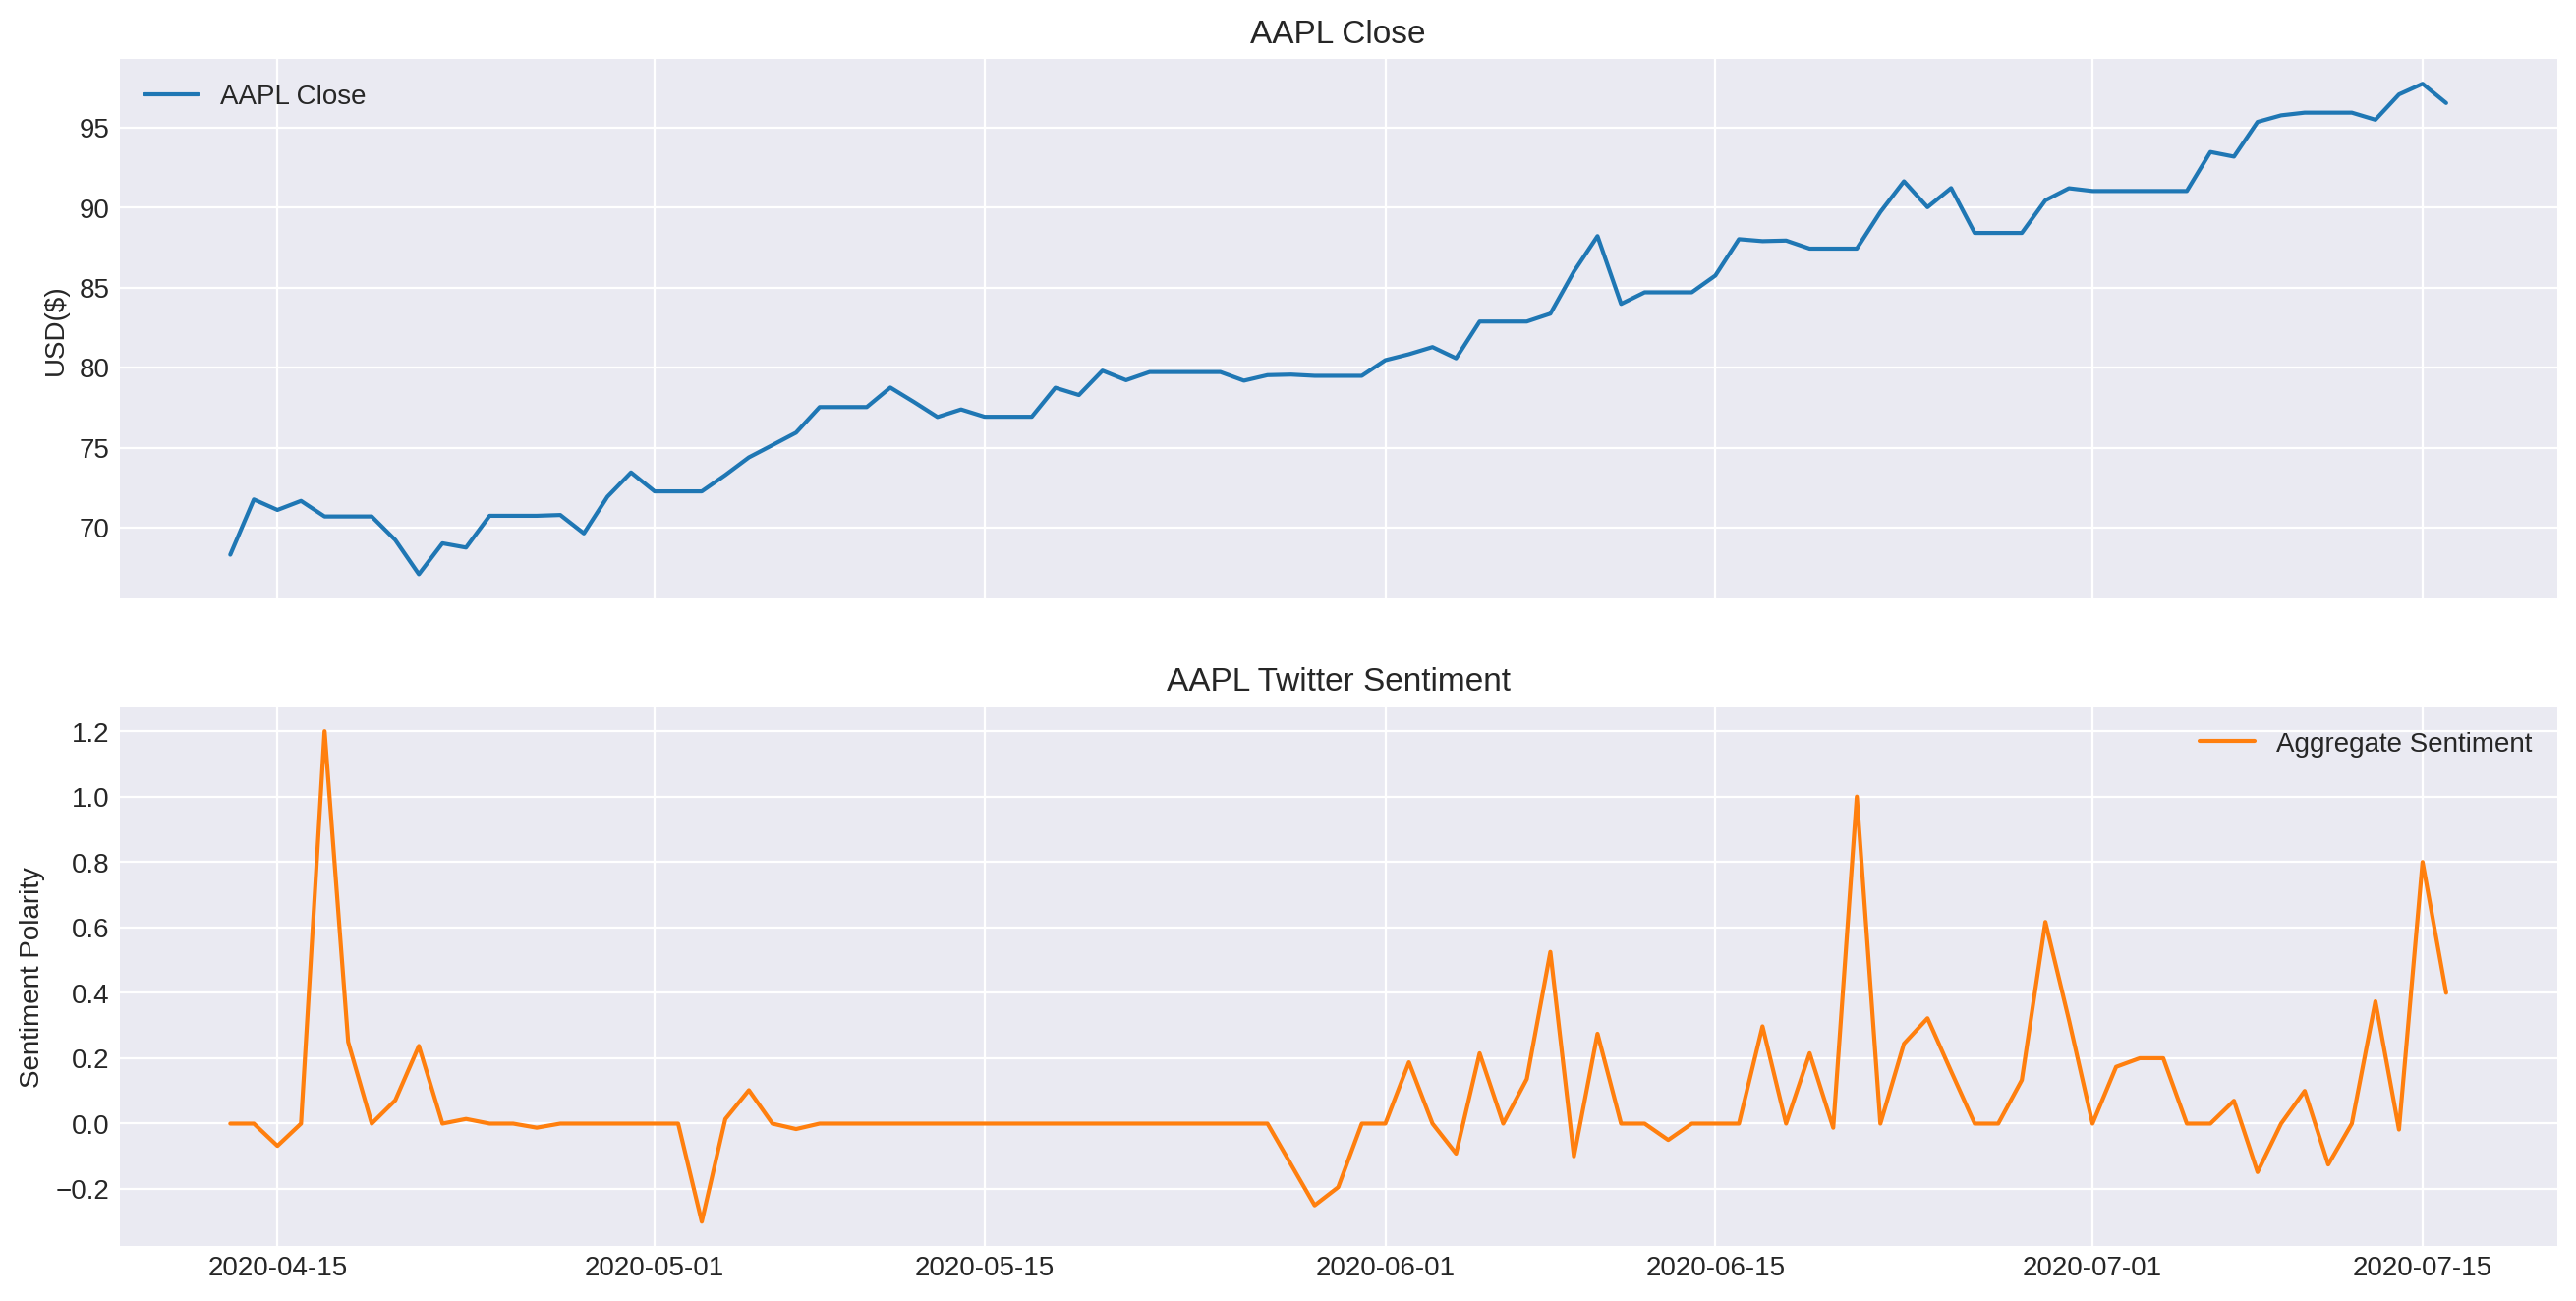

In [ ]:
from textblob import TextBlob
df_pos['polarity'] = df_pos['text'].apply(lambda x: TextBlob(str(x)).sentiment[0]) 
df_neg['polarity'] = df_neg['text'].apply(lambda x: TextBlob(str(x)).sentiment[0]) 
df_neu['polarity'] = df_neu['text'].apply(lambda x: TextBlob(str(x)).sentiment[0]) 

plt.style.use('seaborn-darkgrid')
fig, ax = plt.subplots(2, sharex = True, figsize=(16, 8), dpi=200)

ax[0].plot(sent_close, label = 'AAPL Close')
ax[0].legend(loc='best')
ax[0].set_title('AAPL Close')
ax[0].set_ylabel('USD($)')
# ax[1].plot(df_pos.index, df_pos['polarity'], label = 'Positive')
# ax[1].plot(df_neg.index, df_neg['polarity'], label = 'Negative')
# ax[1].plot(df_neu.index, df_neu['polarity'], label = 'Neutral')
ax[1].plot(agg.index, agg, label = 'Aggregate Sentiment', color = '#ff7f0e')
ax[1].set_ylabel('Sentiment Polarity')
ax[1].legend(loc='best')
ax[1].set_title('AAPL Twitter Sentiment')
plt.show()

In [ ]:
pospol = df_pos['polarity']
negpol = df_neg['polarity']
neupol = df_neu['polarity']

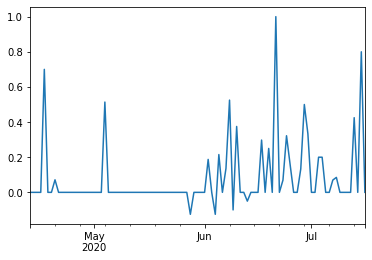

In [ ]:
idx = pd.date_range(df_neu.index.min(), df_neu.index.max())
pos = pd.Series(pospol)
pos.index = pd.DatetimeIndex(pos.index)
pos = pos.resample('D').mean()
pos = pos.reindex(idx)
pos = pos.fillna(0)
pos.plot()

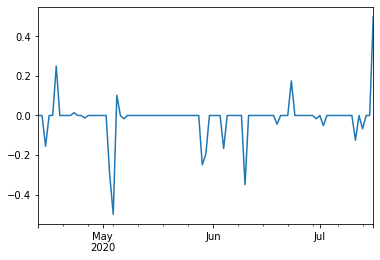

In [ ]:
idx = pd.date_range(df_neu.index.min(), df_neu.index.max())
neg = pd.Series(negpol)
neg.index = pd.DatetimeIndex(neg.index)
neg = neg.resample('D').mean()
neg = neg.reindex(idx)
neg = neg.fillna(0)
neg.plot()

95

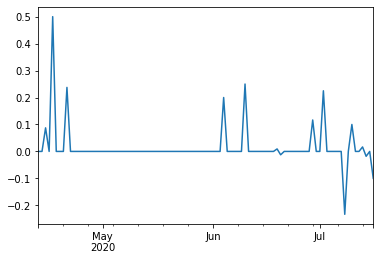

In [ ]:
idx = pd.date_range(df_neu.index.min(), df_neu.index.max())
neu = pd.Series(neupol)
neu.index = pd.DatetimeIndex(neu.index)
neu = neu.resample('D').mean()
neu = neu.reindex(idx)
neu = neu.fillna(0)
neu.plot()
len(neu)

In [ ]:
df_agg = [pos, neg, neu]
aggpol = pd.concat(df_agg, axis=1)
agg = aggpol.sum(axis=1)
mean = aggpol.mean(axis=1)
aggpol.columns.values[0]='Positive'
aggpol.columns.values[1]='Negative'
aggpol.columns.values[2]='Neutral'
aggpol.head()

,Positive,Negative,Neutral
2020-04-13,0.0,0.000000,0.000000
2020-04-14,0.0,0.000000,0.000000
2020-04-15,0.0,-0.155556,0.087455
2020-04-16,0.0,0.000000,0.000000
2020-04-17,0.7,0.000000,0.500000


95

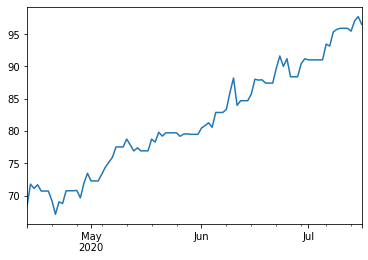

In [ ]:
idx = pd.date_range(df_neu.index.min(), df_neu.index.max())
sent_close = pd.Series(sentiment_close)
sent_close.index = pd.DatetimeIndex(sent_close.index)
sent_close = sent_close.resample('D').mean()
sent_close = sent_close.reindex(idx)
sent_close = sent_close.fillna(method='ffill')
sent_close.plot()
len(sent_close)

In [ ]:
# regression analysis: 
y_3 = sent_close.values
x_3 = aggpol[['Positive', 'Negative', 'Neutral']].values
sent = sm.OLS(y_3,x_3)
sent_results = sent.fit()
sent_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.158
Model:                            OLS   Adj. R-squared (uncentered):              0.131
Method:                 Least Squares   F-statistic:                              5.775
Date:                Sun, 04 Sep 2022   Prob (F-statistic):                     0.00116
Time:                        17:33:07   Log-Likelihood:                         -545.43
No. Observations:                  95   AIC:                                      1097.
Df Residuals:                      92   BIC:                                      1105.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           151.6779     41.263      3.676      0.000      69.725     233.630
x2           -17.9355     80.367     -0.223      0.824    -177.551     141.680
x3            53.2711    110.924      0.480      0.632    -167.033     273.576
==============================================================================
Omnibus:                       72.486   Durbin-Watson:                   0.356
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              350.801
Skew:                          -2.624   Prob(JB):                     6.68e-77
Kurtosis:                      10.816   Cond. No.                         2.98
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
aggpol[['Positive', 'Negative', 'Neutral']].values

In [ ]:
sentiment_close = ohlcv['2020-04-13' :'2020-07-16']['Close']


67

# Fundamental Analysis:

In [ ]:
# Add Ratio Analysis of Fundamentals: balance sheet & cashflow 
apple = yf.Ticker("AAPL")
balance_sheet = apple.balance_sheet.T
cashflow = apple.cashflow.T
financials = apple.financials.T
shares_outstanding = balance_sheet['Common Stock']/ohlcv['Close'][-1]
# Ratio Analysis:
wcap = np.array(balance_sheet['Total Current Assets']/balance_sheet['Total Current Liabilities'])
quick = np.array((balance_sheet['Inventory']+balance_sheet['Total Current Assets'])/balance_sheet['Total Current Liabilities'])
lev = np.array(balance_sheet['Total Liab']/balance_sheet['Total Stockholder Equity'])
eps = np.array(cashflow['Net Income']/shares_outstanding)
pe = np.array(ohlcv['Close'][-1]/eps)
cash = np.array(balance_sheet['Cash']/balance_sheet['Total Current Liabilities'])
netmargin = np.array(financials['Net Income']/financials['Total Revenue'])
rota = np.array(financials['Ebit']/balance_sheet['Total Assets'])
roe = np.array(financials['Net Income']/balance_sheet['Total Stockholder Equity'])

In [ ]:
# Trend Analysis:
plt.figure(figsize = (8,4), dpi=150)
plt.plot(financials['Total Revenue'], label = 'Revenue', linestyle = '-', marker = 's')
plt.plot(cashflow['Net Income'], label = 'Net Income', linestyle = '-', marker = 's')
plt.xticks(ticks = cashflow.index, labels = [2021, 2020, 2019, 2018])
plt.title('Trend Analysis: Revenue and Net Income')
plt.xlabel('Year')
plt.ylabel('$ Hundreds of Billions')
plt.legend()

plt.figure(figsize = (8,4), dpi=150)
year = [2021, 2020, 2019, 2018]
plt.bar(year, wcap)
plt.plot(year, wcap, label = 'Trendline', marker = '.', color = 'orange')
for i in (range(len(wcap))):
        plt.text(year[i],wcap[i],wcap[i].round(2),ha = 'center', va = 'bottom', color = '#0b559f')
plt.xticks(ticks = year, labels = [2021, 2020, 2019, 2018])
plt.title('Trend Analysis: Working Capital Ratio')
plt.xlabel('Year')

plt.figure(figsize = (8,4), dpi=150)
plt.bar(year, quick)
plt.plot(year, quick, label = 'Trendline', marker = '.', color = 'orange')
for i in (range(len(quick))):
        plt.text(year[i],quick[i],quick[i].round(2),ha = 'center', va = 'bottom', color = '#0b559f')
plt.xticks(ticks = year, labels = [2021, 2020, 2019, 2018])
plt.title('Trend Analysis: Quick Ratio')
plt.xlabel('Year')

plt.figure(figsize = (8,4), dpi=150)
plt.bar(year, lev)
plt.plot(year, lev, label = 'Trendline', marker = '.', color = 'orange')
for i in (range(len(lev))):
        plt.text(year[i],lev[i],lev[i].round(2),ha = 'center', va = 'bottom', color = '#0b559f')
plt.xticks(ticks = year, labels = [2021, 2020, 2019, 2018])
plt.title('Trend Analysis: Leverage Ratio')
plt.xlabel('Year')

plt.figure(figsize = (8,4), dpi=150)
plt.bar(year, eps)
plt.plot(year, eps, label = 'Trendline', marker = '.', color = 'orange')
for i in (range(len(eps))):
        plt.text(year[i],eps[i],eps[i].round(2),ha = 'center', va = 'bottom', color = '#0b559f')
plt.xticks(ticks = year, labels = [2021, 2020, 2019, 2018])
plt.title('Trend Analysis: Earnings Per Share')
plt.xlabel('Year')

plt.figure(figsize = (8,4), dpi=150)
plt.bar(year, pe)
plt.plot(year, pe, label = 'Trendline', marker = '.', color = 'orange')
for i in (range(len(pe))):
        plt.text(year[i],pe[i],pe[i].round(2),ha = 'center', va = 'bottom', color = '#0b559f')
plt.xticks(ticks = year, labels = [2021, 2020, 2019, 2018])
plt.title('Trend Analysis: P:E Ratio')
plt.xlabel('Year')

plt.figure(figsize = (8,4), dpi=150)
plt.bar(year, cash)
plt.plot(year, cash, label = 'Trendline', marker = '.', color = 'orange')
for i in (range(len(cash))):
        plt.text(year[i],cash[i],cash[i].round(2),ha = 'center', va = 'bottom', color = '#0b559f')
plt.xticks(ticks = year, labels = [2021, 2020, 2019, 2018])
plt.title('Trend Analysis: Cash Ratio')
plt.xlabel('Year')

plt.figure(figsize = (8,4), dpi=150)
plt.bar(year, netmargin)
plt.plot(year, netmargin, label = 'Trendline', marker = '.', color = 'orange')
for i in (range(len(netmargin))):
        plt.text(year[i],netmargin[i],round(netmargin[i],2),ha = 'center', va = 'bottom', color = '#0b559f')
plt.xticks(ticks = year, labels = [2021, 2020, 2019, 2018])
plt.title('Trend Analysis: Net Margin')
plt.xlabel('Year')

plt.figure(figsize = (8,4), dpi=150)
plt.bar(year, rota)
plt.plot(year, rota, label = 'Trendline', marker = '.', color = 'orange')
for i in (range(len(rota))):
        plt.text(year[i],rota[i],round(rota[i],2),ha = 'center', va = 'bottom', color = '#0b559f')
plt.xticks(ticks = year, labels = [2021, 2020, 2019, 2018])
plt.title('Trend Analysis: Return on Total Assets')
plt.xlabel('Year')

plt.figure(figsize = (8,4), dpi=150)
plt.bar(year, roe)
plt.plot(year, roe, label = 'Trendline', marker = '.', color = 'orange')
for i in (range(len(roe))):
        plt.text(year[i],roe[i],round(roe[i],2),ha = 'center', va = 'bottom', color = '#0b559f')
plt.xticks(ticks = year, labels = [2021, 2020, 2019, 2018])
plt.title('Trend Analysis: Return on Total Equity')
plt.xlabel('Year')

plt.show();

# ESG Analysis:

In [ ]:
# Add Sustainability
apple = yf.Ticker("AAPL")
sus = apple.sustainability.T
yesg = yesg.get_esg_full('AAPL')
peer = yesg['avg peer ESG']
esg = sus[['environmentScore', 'governanceScore', 'socialScore']].values.sum()
print('AAPL ESG Score: [{}] \nAverage Sector Peer ESG Score: {} \nThe lower the score the better.'.format(esg, peer.values)) # string formatting

AAPL ESG Score: [16.69] 
Average Sector Peer ESG Score: [16.16472727] 
The lower the score the better.


In [ ]:
# Weighted average ESG score for the S&P500? - https://tradewithpython.com/equity-index-score-esg-with-python
import time
from random import randint
import bs4 as bs
import requests
import yfinance as yf
import datetime

resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})
tickers = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text
    tickers.append(ticker)

tickers = [s.replace('\n', '') for s in tickers]

esg_data = pd.DataFrame() #empty df for attaching all ticker's data response
for ticker in tickers:
     print(ticker) #just FYI to know your code is running
     ticker_name = yf.Ticker(ticker)
     try:
          if ticker_name.sustainability is not None: #if no response from Yahoo received, it will pass to next ticker
               ticker_df = ticker_name.sustainability.T #response dataframe
               ticker_df['symbol'] = ticker #adding new column 'symbol' in response df
               esg_data = esg_data.append(ticker_df) #attaching the response df to esg_data
               time.sleep(randint(2,8)) #delaying the fetch of data for 2-8 seconds
     except (IndexError, ValueError) as e: #in case yfinance API misbehaves
          print(f'{ticker} did not run') #FYI
          pass

esg_tickers = esg_data['symbol']
no_esg_data = list(set(tickers) - set(esg_tickers))
#set function removes all duplicates in a list and the above gives us the
#difference between our original ticker list and our esg_data ticker list
print(no_esg_data)

new_esg_df = esg_data[['symbol', 'socialScore', 
               'governanceScore', 'totalEsg', 'environmentScore']]
#the above basically takes the columns mentioned above and assigns into new df.

main_df = pd.DataFrame() #creating empty df to store data

for ticker in tickers:
     ticker_name = yf.Ticker(ticker)
     try:
          ticker_info = ticker_name.info
          ticker_df = pd.DataFrame.from_dict(ticker_info.items()).T
          #the above line will parse the dict response into a DataFrame
          ticker_df.columns = ticker_df.iloc[0]
          #above line will rename all columns to first row of dataframe
          #as all the headers come up in the 1st row, next line will drop the 1st line
          ticker_df = ticker_df.drop(ticker_df.index[0])
          main_df = main_df.append(ticker_df)
          print(f'{ticker} + Complete')
     except (IndexError, ValueError) as e:
          print(f'{ticker} + Data Not Found')

filtered_df = main_df[['symbol', 'sector', 'previousClose', 'sharesOutstanding']]
filtered_df['newMarketCap'] = filtered_df['previousClose'] * filtered_df['sharesOutstanding']
total_index_mcap = filtered_df['newMarketCap'].sum()
filtered_df['marketWeight'] = (filtered_df['newMarketCap']/total_index_mcap)*100
final_df = filtered_df.merge(new_esg_df, how='left', on='symbol')
final_df[~final_df['totalEsg'].notnull()]

final_esg_df = pd.DataFrame() #empty df

sector_list = final_df['sector'].unique().tolist() #getting list of sectors in index

#looping over each sector and apply .mean to calculate average
for sector in sector_list:
    sector_df = final_df[final_df['sector'] == sector]
    sector_df['socialScore'].fillna(round(sector_df['socialScore'].mean(),2), inplace=True)
    sector_df['governanceScore'].fillna(round(sector_df['governanceScore'].mean(),2), inplace=True)
    sector_df['totalEsg'].fillna(round(sector_df['totalEsg'].mean(),2), inplace=True)
    sector_df['environmentScore'].fillna(round(sector_df['environmentScore'].mean(),2), inplace=True)

    final_esg_df = final_esg_df.append(sector_df)

#also adding the weighted average columns into this new final_esg_df
final_esg_df['mktweightedEsg'] = (final_esg_df['marketWeight'] * final_esg_df['totalEsg'])/100
final_esg_df['mktweightedEnvScore'] = (final_esg_df['marketWeight'] * final_esg_df['environmentScore'])/100
final_esg_df['mktweightedSocScore'] = (final_esg_df['marketWeight'] * final_esg_df['socialScore'])/100
final_esg_df['mktweightedGovScore'] = (final_esg_df['marketWeight'] * final_esg_df['governanceScore'])/100

print('Total Environment Score: {}'.format(round(final_esg_df['mktweightedEnvScore'].sum(),2)))
print('Total Social Score: {}'.format(round(final_esg_df['mktweightedSocScore'].sum(),2)))
print('Total Governance Score: {}'.format(round(final_esg_df['mktweightedGovScore'].sum(),2)))
print('Total ESG Score: {}'.format(round(final_esg_df['mktweightedEsg'].sum(),2)))

# Credit Risk Evaluation:

In [ ]:
recovery_rate = financials['Interest Expense']/cashflow['Change To Liabilities']
recovery_rate[0]

-0.18890158548778746

In [ ]:
# AAPL 2.400% 13Jan2023 Corp (USD)
price = 99.987
coupon = 0.024
bond_yield = coupon/price
rf = 0.0263

In [ ]:
# Hazard Rate - The amount the bondholder expects to lose is priced into the bond yield.
y = bond_yield-rf # bond yield above rf
R = recovery_rate[0] # Expected recovery rate
h = y/(1-R)
h

-0.02191936583653514

In [ ]:
# Contingent Claims Analysis - Merton - Provides Accurate Ranking of Credit Default Risk

mktcap_data = [2503000000000,2901000000000, 2255000000000, 1287000000000, 746070000000, 860880000000, 608960000000] #https://companiesmarketcap.com/apple/marketcap/
vol_firm_value = np.std(mktcap_data)
# AAPL 2.400% 13Jan2023 Corp (USD)750000000*
facevalue_debt = 99.987
rf = 0.0263
vol_firm_value

def ds(S0, K, T, r, sig):
    d1 = (np.log(S0/K)+(r+sig**2/2)*T)/(sig*np.sqrt(T))
    d2 = d1 - sig*np.sqrt(T)
    return (d1, d2)

def normds(S0, K, T, r, sig):
    d1 = (np.log(S0/K)+(r+sig**2/2)*T)/(sig*np.sqrt(T))
    d2 = d1 - sig*np.sqrt(T)
    Nd1 = norm.cdf(d1)
    Nd2 = norm.cdf(d2)
    return (Nd1, Nd2)
    
def normnegds(S0, K, T, r, sig):
    d1 = (np.log(S0/K)+(r+sig**2/2)*T)/(sig*np.sqrt(T))
    d2 = d1 - sig*np.sqrt(T)
    Nd1 = norm.cdf(-d1)
    Nd2 = norm.cdf(-d2)
    return (Nd1, Nd2)

def BS_EP_call(S0, K, T, r, sig):
    d1 = (np.log(S0/K)+(r+sig**2/2)*T)/(sig*np.sqrt(T))
    d2 = d1 - sig*np.sqrt(T)

    V = S0*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    return V 

S0 = 2503000000000 # Value of Firm
K = facevalue_debt # Face Value of Bonds
T = 1
sig = vol_firm_value # Volatility of Firm Value
r = rf # rf

E = BS_EP_call(S0, K, T, r, sig)
D = S0-E # Value of Debt
R = np.log(K/D) # Required rate of return on Debt when rf = r
print("Value of Firm Equity: " + str(BS_EP_call(S0, K, T, r, sig)))

# As debt increases constitution of capital structure, financial risk increases,
# along with probability of default, thus, raising the required rate of return to compensate for risk.

# Fair Value of the Guarantee on Debt:
G = (K*np.exp(-r)-D).round(2)
print("Value of Guarantee: " + str(G))


# Risk neutral probability company will default on debt = N(-d2)
ds(S0, K, T, sig, r)
d2 = ds(S0, K, T, r, sig)[1]
Default_risk = norm.cdf(-(d2))
print("Risk of company defaulting: " + str(Default_risk))


# Expected Loss on Debt:
elossd = (K*np.exp(-r)-D)/K*np.exp(-r)
erecov = (Default_risk-elossd)/Default_risk
print ("Expected recovery in the event of default: " + str(erecov))

Value of Firm Equity: 2503000000000.0
Value of Guarantee: 97.39
Risk of company defaulting: 1.0
Expected recovery in the event of default: 0.05124055963219076


# Option IV Smile:

In [ ]:
# Plot IV of options from options chain 
aapl = yf.Ticker("AAPL")
opt = aapl.option_chain('2022-10-07')

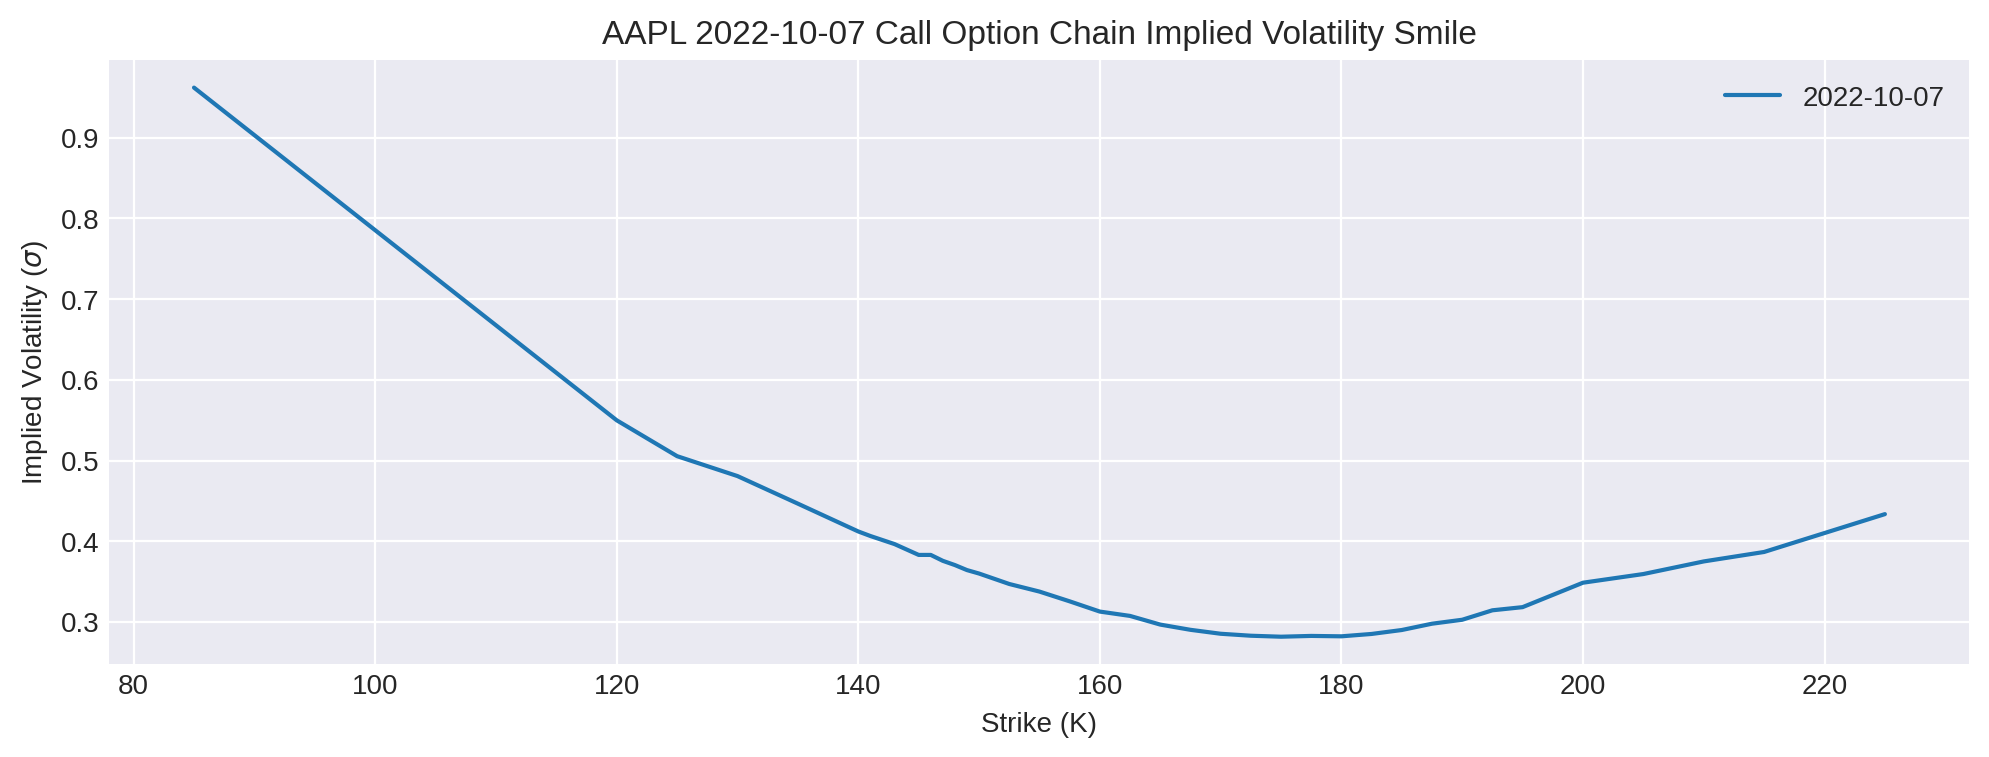

In [ ]:
calls = opt.calls
iv = calls[['strike', 'impliedVolatility']]
fig, ax = plt.subplots(figsize=(12,4), dpi=200)
ax.plot(iv['strike'], iv['impliedVolatility'], label='2022-10-07')
ax.legend(loc='best')
ax.set_title('AAPL 2022-10-07 Call Option Chain Implied Volatility Smile')
ax.set_xlabel('Strike (K)')
ax.set_ylabel(r'Implied Volatility ($\sigma$)')
plt.show();